# Task 3

In [116]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import numpy as np
import random
from copy import deepcopy   

Let's import sudoku from file( we accept only '0' or 'x' as free squares)

In [115]:
def import_sudoku(path):
    with open(path) as file:
        data = iter(file.read())
    
    sudoku = [[None] * 9 for _ in range(9)]
    free_squares = [[[] for _ in range(3)] for _ in range(3)]
    cnt = 0
    for i in range(9):
        for j in range(9):
            for char in data:
                if char  == 'x' or char == '0':
                    free_squares[i // 3][j // 3].append((i, j))
                    cnt += 1
                    break
                if char.isdigit() and '1' <= char <= '9':
                    sudoku[i][j] = int(char)
                    break
    
    return sudoku, free_squares,cnt

Let's redefine our probability function 

In [117]:
def probability(old, new, temp): return 1.0 if old > new else np.exp((old - new) / max(temp, 1e-10))

And add temperatures implementations

In [424]:
def temp_exp(iteration, par):
    return par ** iteration

def temp_log(iteration, par):
    return 1 / np.log(1 + par * iteration)

def temp_diff(iteration, par):
    return max(0, 1 - par * iteration)

Now we will define energy function for sudoku. Cost function take the sum of the repetitions of digits occurring in the rows of the 9 × 9 block, the columns of the 9 × 9 block and the 3 × 3 blocks

In [425]:
def count_repetitions(list): # calucate repetitions 
    occurrences = [-1] * 9
    for n in list: occurrences[n-1] += 1 
    return sum(v for v in occurrences if v > 0)


def sudoku_energy(sudoku):
    energy = 0
    
    # Checking rows and columns
    for i in range(9):
        energy += count_repetitions([sudoku[i][j] for j in range(9)])
        energy += count_repetitions([sudoku[j][i] for j in range(9)])
    
    # Checking 3 x 3 blocks
    for block_row in range(3):
        for block_col in range(3):
            block_values = []
            for i in range(3):
                for j in range(3):
                    block_values.append(sudoku[block_row*3 + i][block_col*3 + j])
            energy += count_repetitions(block_values)
    
    return energy

When it comes to generating neighboring states, i decided to randomly swap values within the randomly chose 3x3 block. If there is a possiblity we generate 2 values with generate_random_swap function adn then swap it solve function. This operation is save (number of distincit digits in every block stays the same) and reversable.

It should enable to solve all possible sudoku problems, but sometimes it will demand lot of calculations or restarts.

In [426]:
def generate_random_swap(free):
    while 1:
        row,col = random.randint(0, 2), random.randint(0, 2)
        if len(free[row][col]) > 1: return random.sample(free[row][col], 2)

Before calcualtion we need to fill the sudoku, that every 3x3 block includes all 1...9 numbers only

In [427]:
def fill_sudoku(sudoku, free):
    for row in range(3):
        for col in range(3):
            #get all non-free cells in this block
            fixed = {sudoku[row*3+i][col*3+j] 
                    for i in range(3) for j in range(3)
                    if (row*3+i, col*3+j) not in free[row][col]}
            
            missing = list(set(range(1, 10)) - fixed) # generate al mising numbers and suffle it
            random.shuffle(missing)
            
            for (i, j), num in zip(free[row][col], missing): sudoku[i][j] = num # reset free cells
        
            free[row][col] = [] if len(free[row][col]) == 1 else free[row][col] # clean single-digit list

We need function to visualize sudoku

In [428]:
def draw_sudoku(sudoku, ax):
    ax.axis('off')
    ax.set_aspect('equal')
    ax.set_xlim([-1, 9])
    ax.set_ylim([1, -9])
    for i in range(9):
        for j in range(9):
            ax.text(j, i-8+0.05, sudoku[i][j], fontsize=5, horizontalalignment='center', verticalalignment='center')
    for i in range(10):
        linewidth = 0.5 if i % 3 == 0 else 0.2
        for (xs, ys) in [([-0.5, 8.5], [-i+0.5] * 2), ([i-0.5] * 2, [0.5, -8.5])]:
            ax.add_line(lines.Line2D(xs, ys, linewidth=linewidth, color='black', axes=ax))

And finally the main function

In [ ]:
#iterations = []
#free_squares = [] 
def show_sudoku(*sudokus, dpi=600):
    fig = plt.figure(figsize=(len(sudokus), 1), dpi=dpi)
    for i, sudoku in enumerate(sudokus, 1):
        draw_sudoku(sudoku, fig.add_subplot(1, len(sudokus), i))
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    plt.show()
    
def show_plot(values, dpi=600):
    fig = plt.figure(figsize=(6, 2))
    ax = fig.add_subplot(1, 1, 1)        
    ax.plot(values, linewidth=0.5, color='green')
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    plt.title("Enenrgy levels")
    plt.tight_layout()

def solve( filename, temp_func_name='exp', temp_param=0.9999, max_iterations=100000):
    original, free, cnt = import_sudoku(filename) # import sudoku from the file
    
    sudoku = deepcopy(original)
    fill_sudoku(sudoku, free) # fill with numbers

    old_energy = sudoku_energy(sudoku) # find starting energy
    energies = [old_energy] # energy list to track progress
    
    # Set temperature function 
    if temp_func_name == 'exp':
        temperature = lambda i: temp_exp(i, temp_param)
    elif temp_func_name == 'log':
        temperature = lambda i: temp_log(i, temp_param)
    elif temp_func_name == 'diff':
        temperature = lambda i: temp_diff(i, temp_param)
    else:
        raise ValueError("No idea")
    
    for iteration in range(max_iterations):
        temp = temperature(iteration) # find temperature

        (i1, j1), (i2, j2) = generate_random_swap(free)
        sudoku[i1][j1], sudoku[i2][j2] = sudoku[i2][j2], sudoku[i1][j1] # swap two numbers in block

        new_energy = sudoku_energy(sudoku) # find new energy and add it into list
        energies.append(new_energy)
            
        if new_energy == 0: # if all numbers are placed correctly
            # print('Solution found after {} iterations'.format(iteration)) debuging option
            show_sudoku(original, sudoku, dpi=1200)
            ##free_squares.append(cnt)
            #iterations.append(iteration)
            break

        prob = probability(old_energy, new_energy, temp) # calculate probablitiy 
        rand = random.uniform(0, 1)

        if new_energy < old_energy or rand < prob: old_energy = new_energy # set energy or back swap
        else: sudoku[i1][j1], sudoku[i2][j2] = sudoku[i2][j2], sudoku[i1][j1]

        # if iteration % 1000 == 999:  print('{}\t{}\t{:.8f}\t{:.8f}'.format(iteration, new_energy, temp, prob)) # every 1k iterations give note about the progress
    

    show_plot(energies)
    #iterations.append(iteration)
    #free_squares.append(cnt)
    #return sudoku, energies

### Testing

I found some example sudokus in leetcode problems and projecteuler and they became my test sources. They are accesiable in sudoku/przyklady folder.

In [430]:
numbers = [2, 3, 5, 10, 12, 15, 20, 25, 30, 35, 40, 45, 47, 48]
paths = [f"sudoku_przyklady/{num}.txt" for num in numbers]

Based on sudokus above and others, algorithm sometimes need few tries to accomplish solution, so I tested it more manually in order not to while True on test and wait 30min. I tested valid sudokus of different number of free squres number and checked number of iterations for algorithm

In [431]:
# results
iterations = [8487, 10171, 29701, 4597, 17967, 10785, 20677, 9645, 14652, 12135, 4959, 14059, 7472, 11161, 14732, 7453, 8374, 1571, 2432, 2911, 3112, 129, 710, 53]
free_squares = [49, 51, 53, 45, 49, 55, 49, 53, 51, 49, 55, 53, 56, 60, 62, 44, 41, 37, 36, 34, 31, 29, 25, 21]


Data presented below

Text(0, 0.5, 'Iterations')

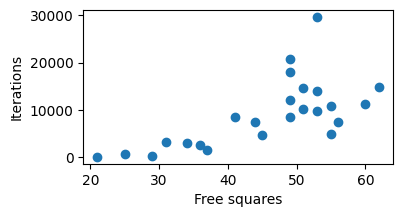

In [432]:
plt.scatter(free_squares, iterations)
plt.xlabel('Free squares')
plt.ylabel('Iterations')

Algorithm exponentialy takes more time to process sudokus with more free squres( number of empty squares on the start). All cases were tested by using exponential temperature function.

#### More testing

Example solution with energy levels

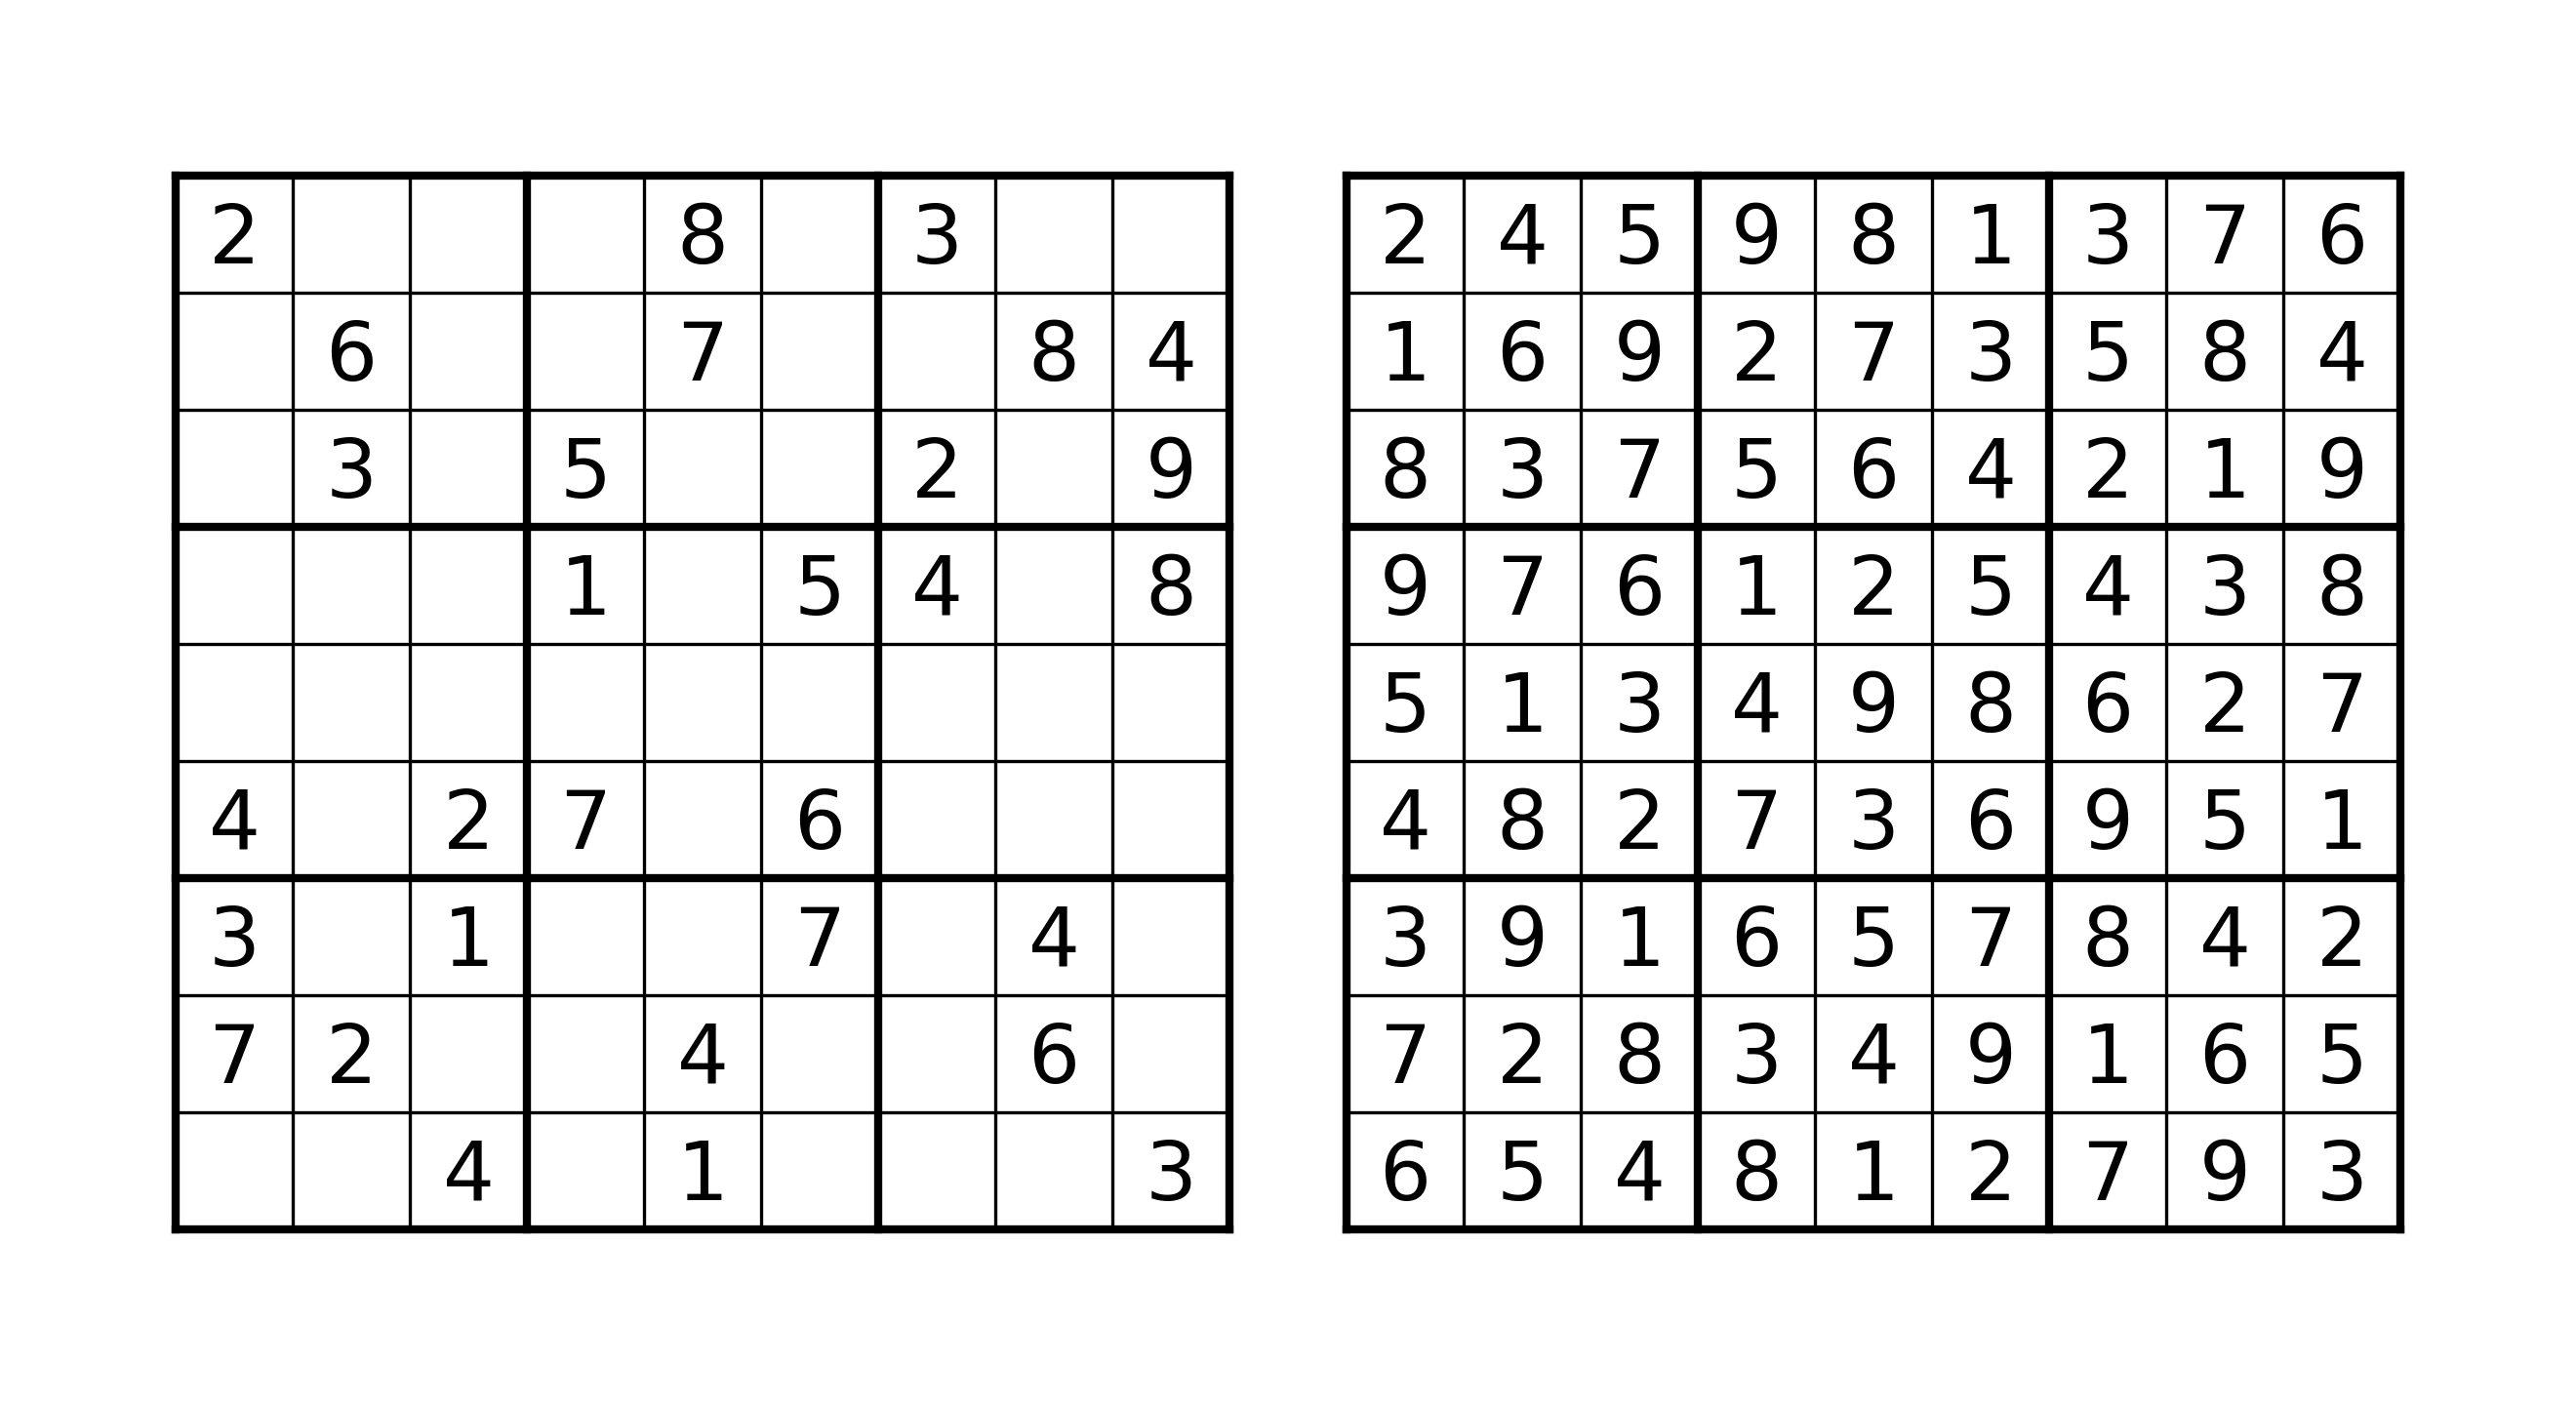

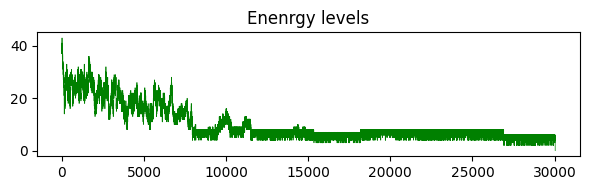

In [435]:
solve("sudoku_przyklady/2.txt",max_iterations=3*10**5)


Now let's compare temperatures functions for exmaple sudokus

/tmp/ipykernel_32760/1657514981.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 / np.log(1 + par * iteration)


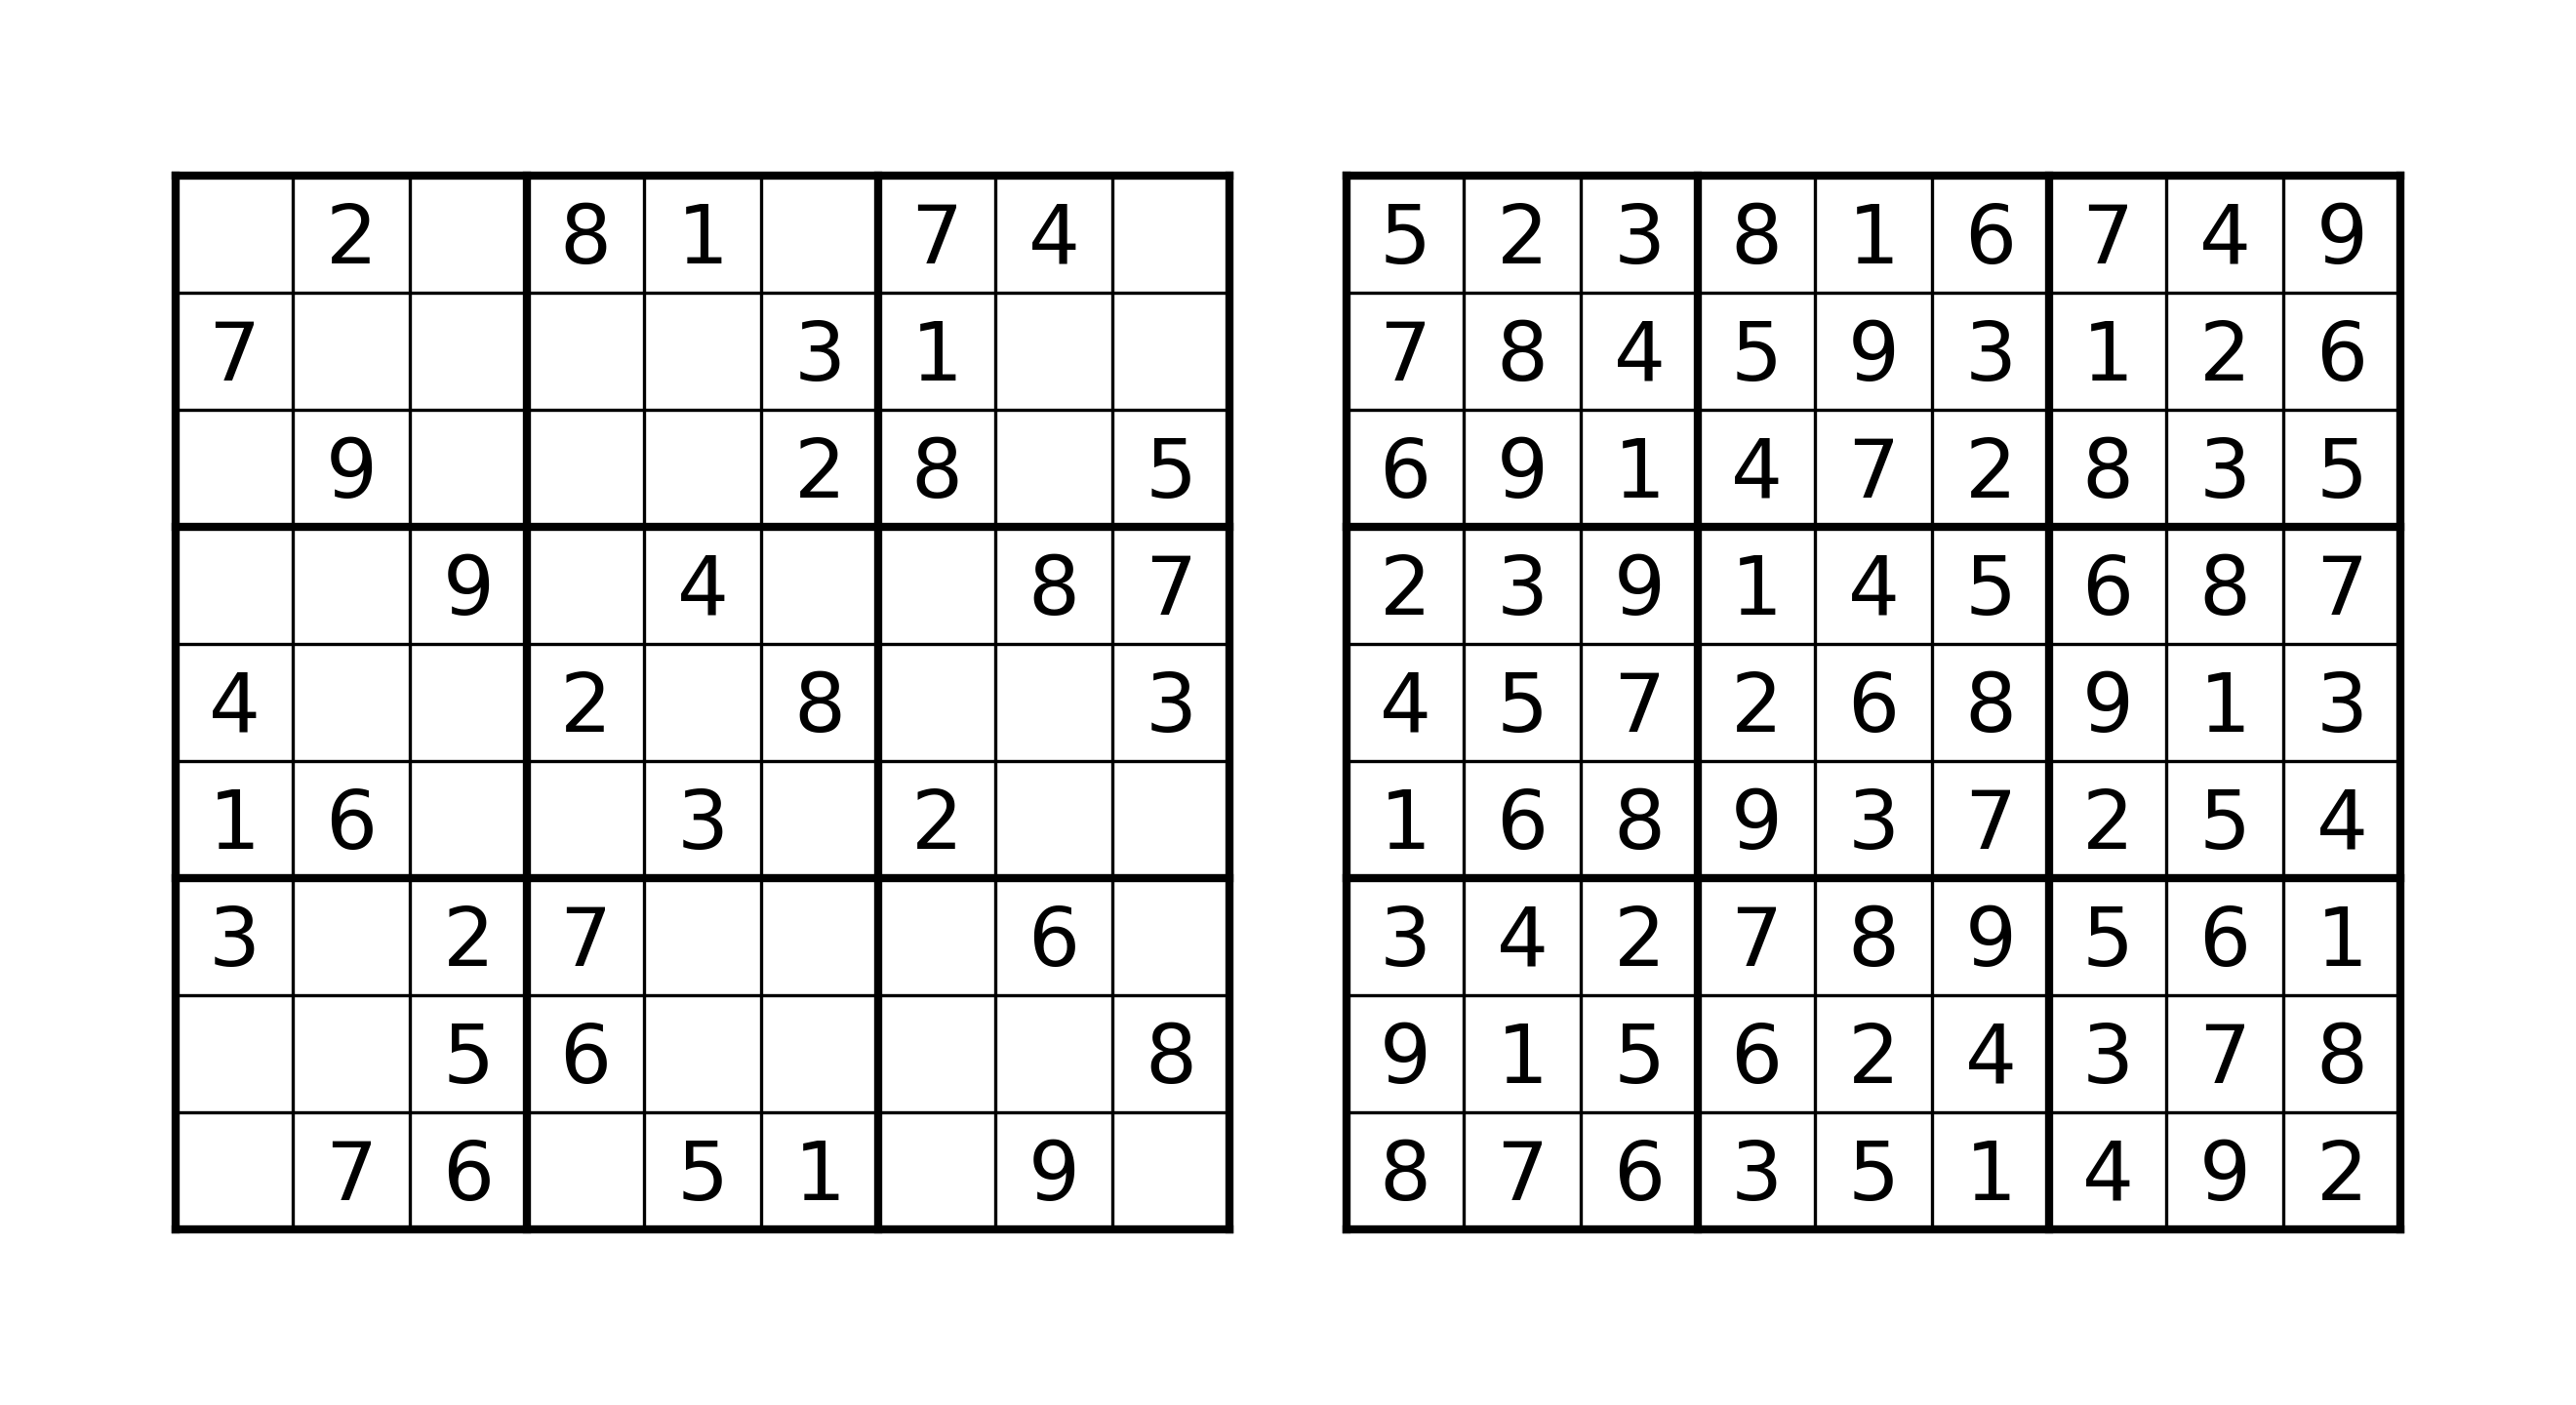

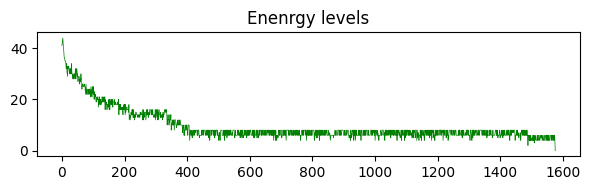

In [436]:
solve("sudoku_przyklady/5.txt",max_iterations=10**5,temp_func_name="log",temp_param=0.5)

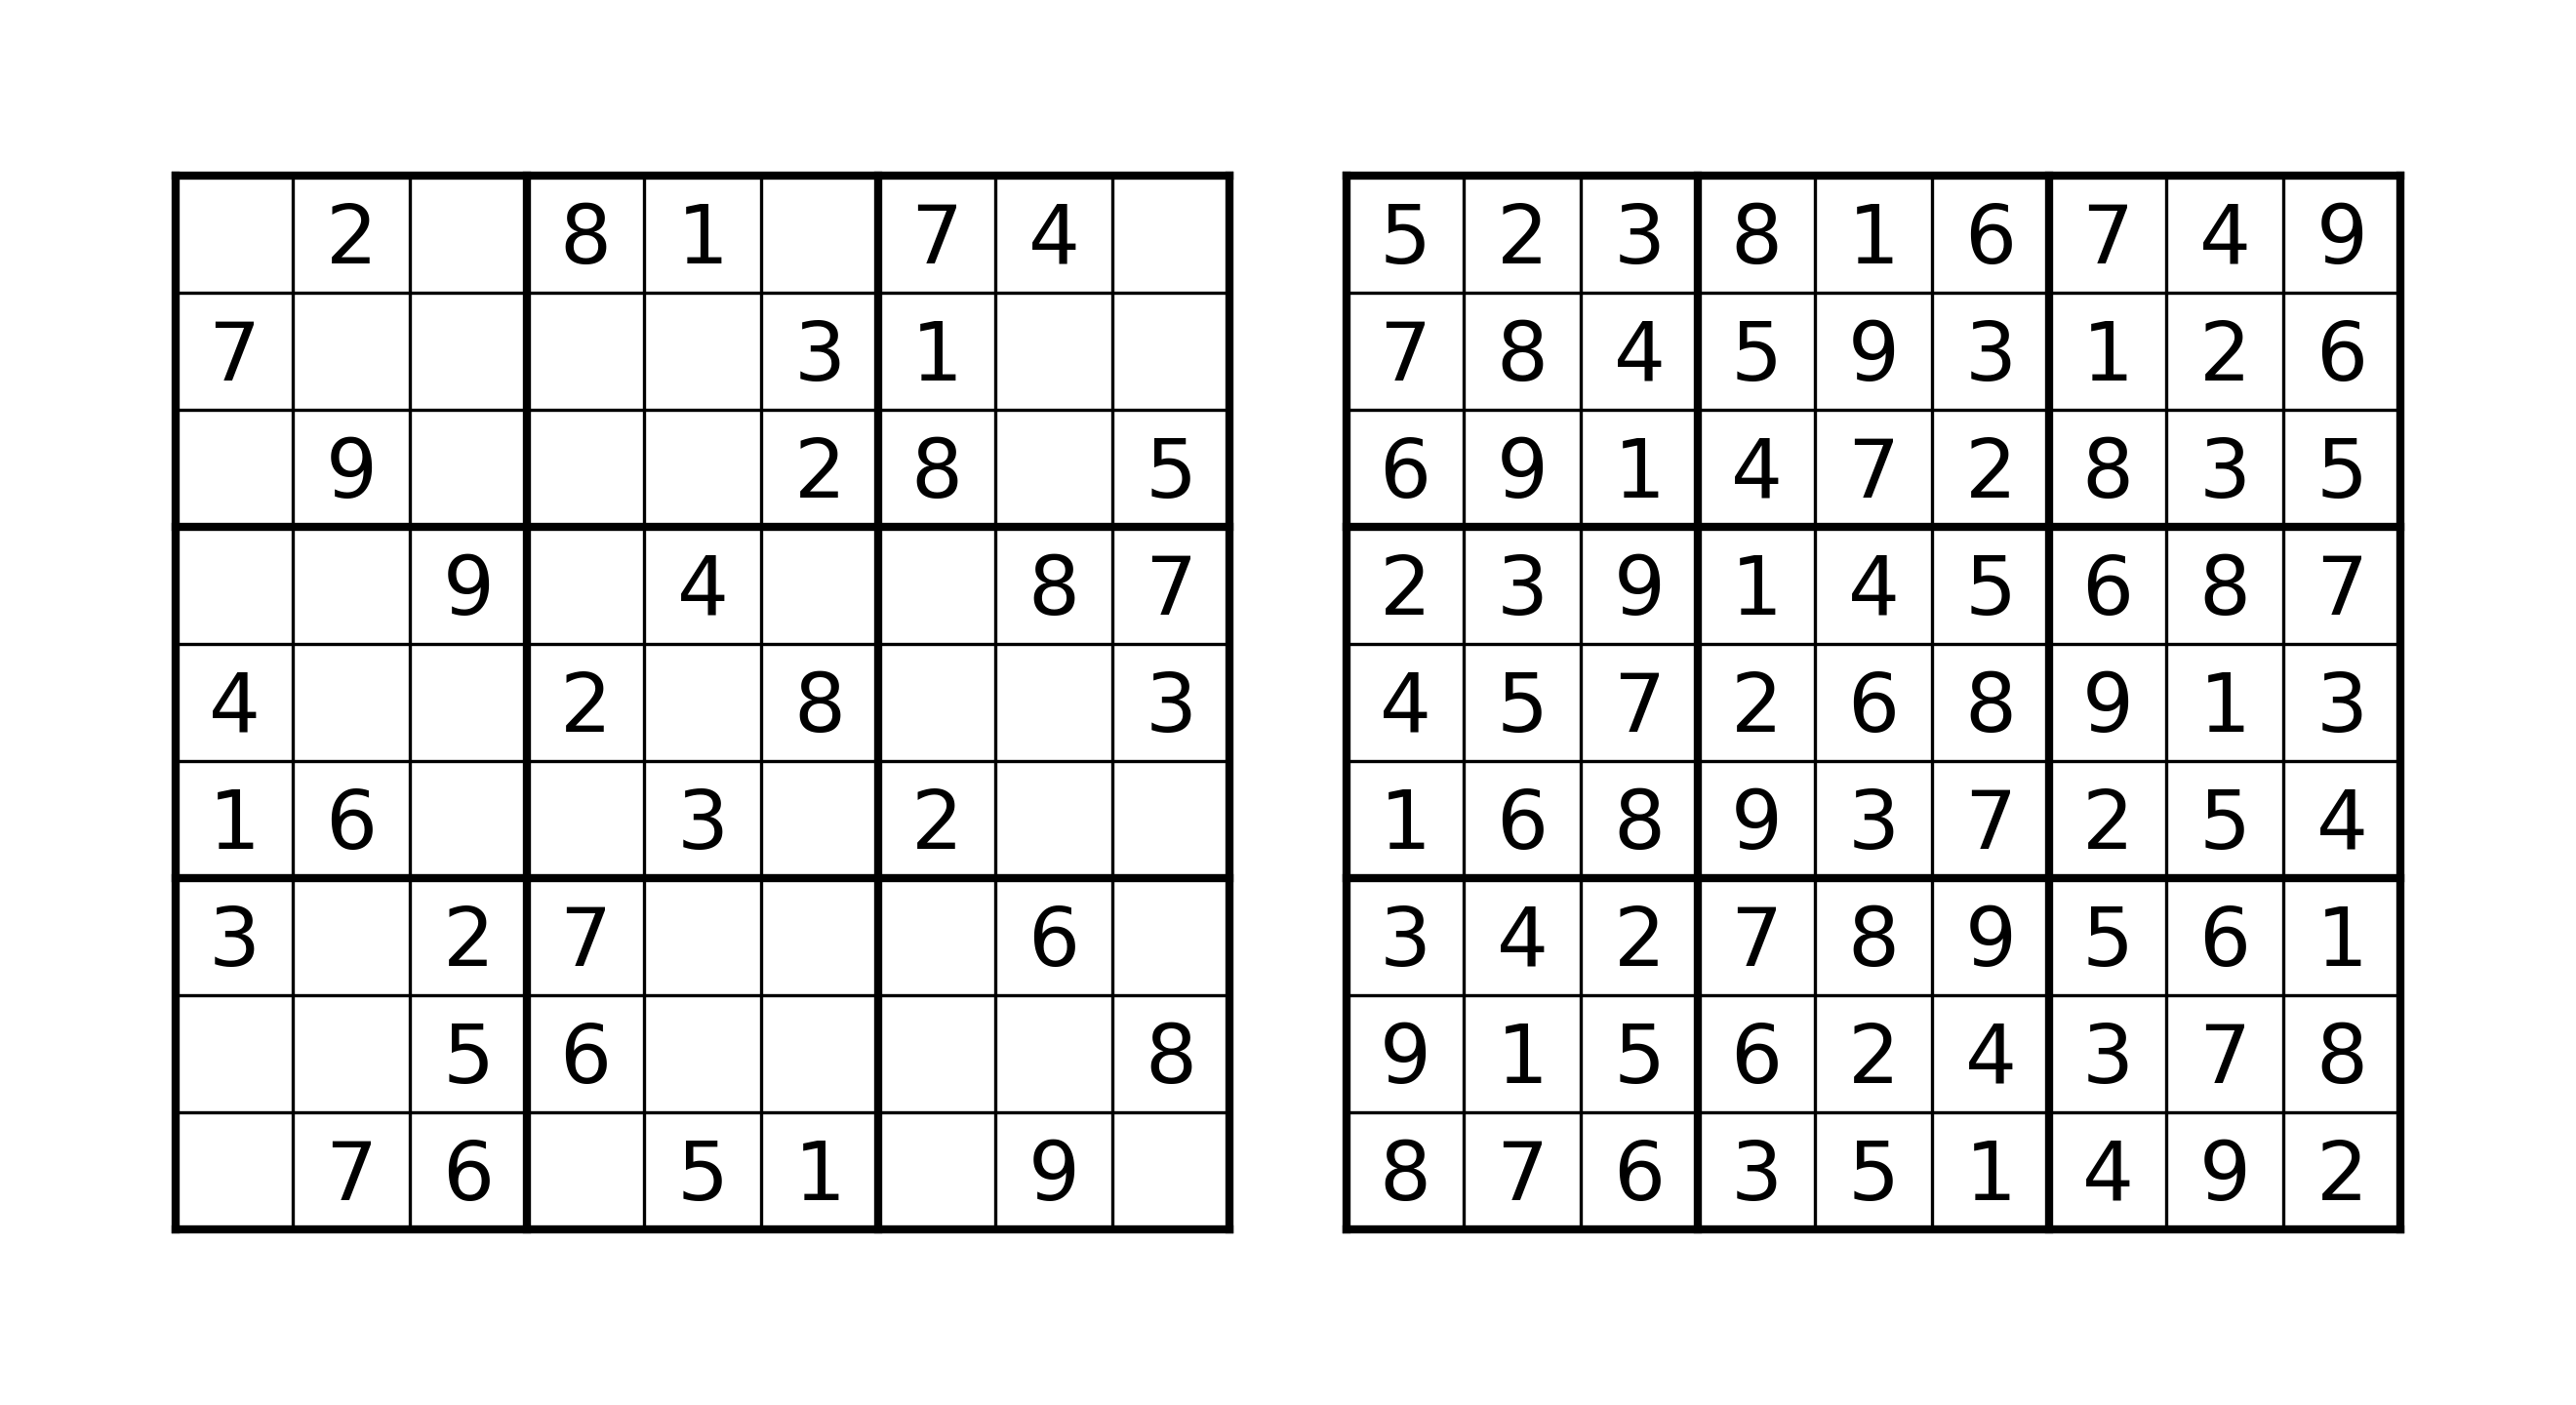

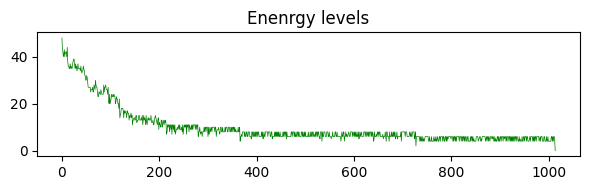

In [437]:
solve("sudoku_przyklady/5.txt",max_iterations=10**5,temp_func_name="exp",temp_param=0.99)

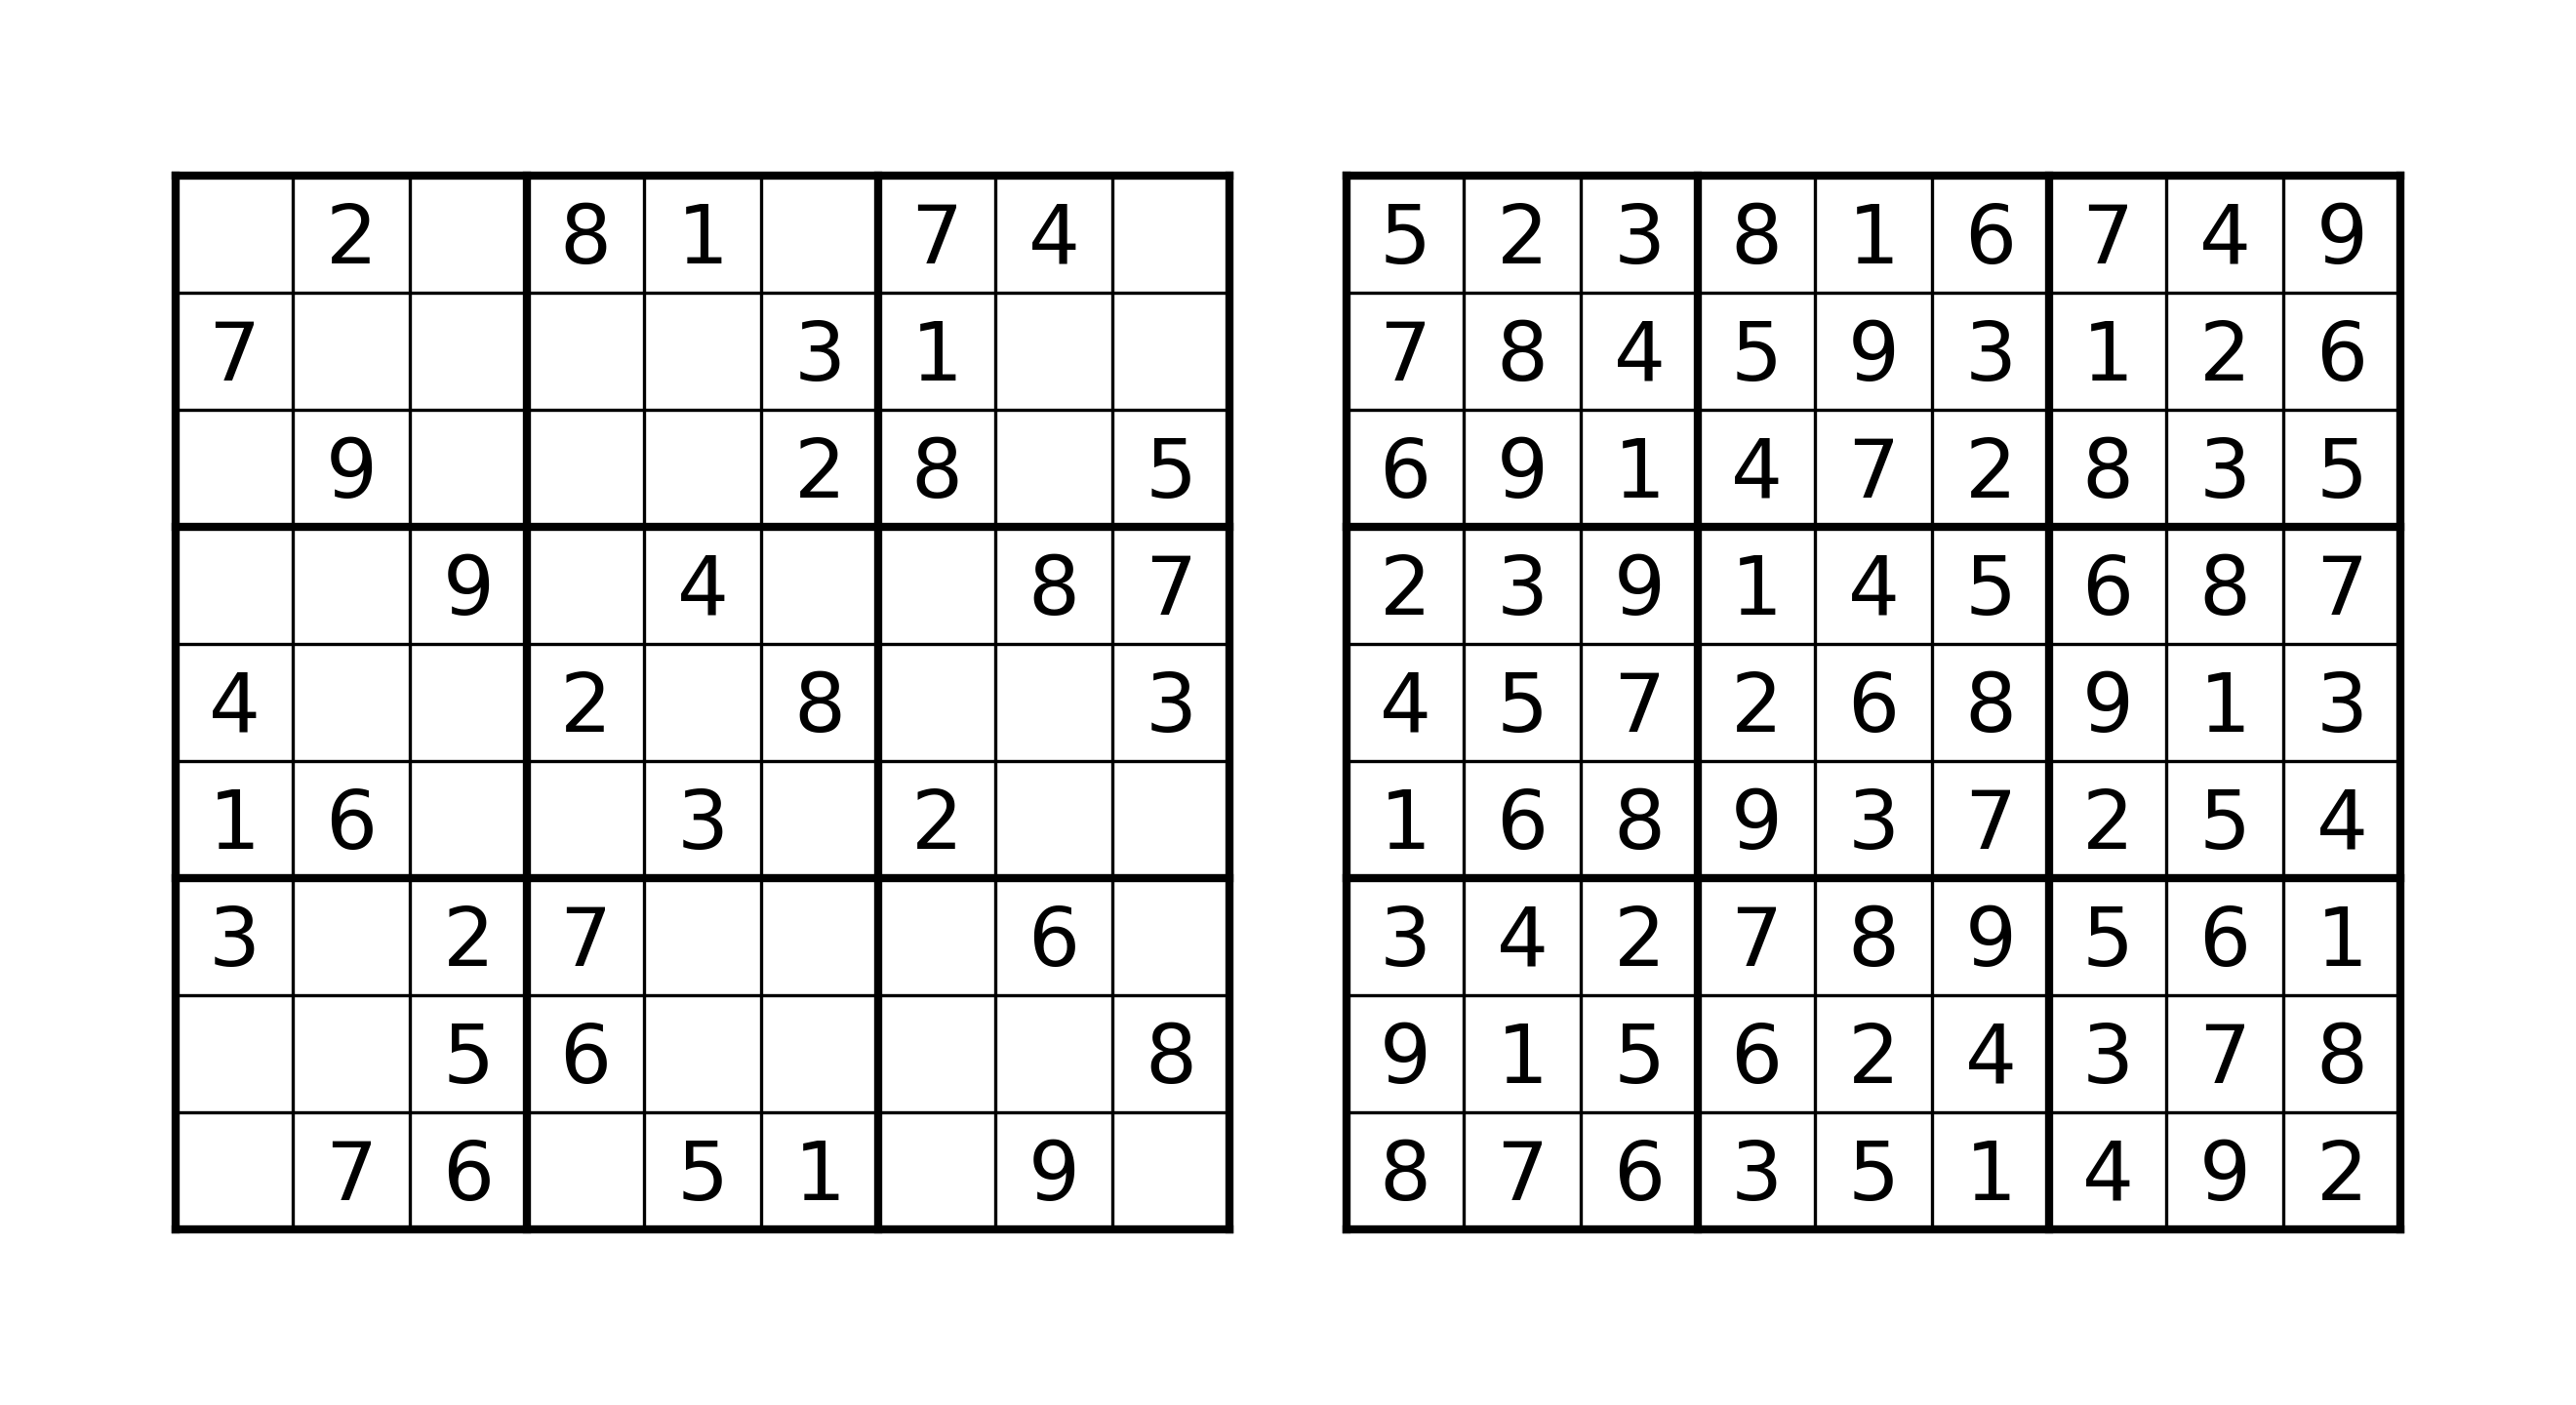

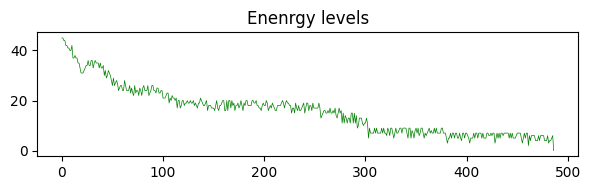

In [438]:
solve("sudoku_przyklady/5.txt",max_iterations=10**5,temp_func_name="diff",temp_param=0.01)

As we can see all temperatures functions work properly and calculate the same correct answer.

However, they can sometimes, faild(example below). What's characteristic about annealing, it can't ensure that every time it will solve the problem correctly. Sometimes algorithm needs more "tries" to solve problem, because of stochstical approach. It is very hard for the algorithm to fight against hardest sudoku problems

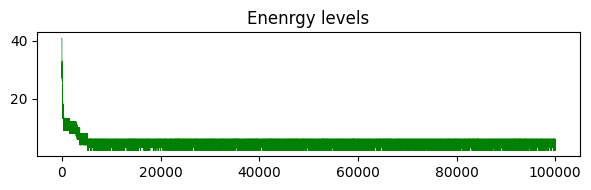

In [440]:
solve("sudoku_przyklady/15.txt",max_iterations=10**5,temp_func_name="diff",temp_param=0.01)
# sudoku solution wasnt found so it is not displayed here

Some other solutions

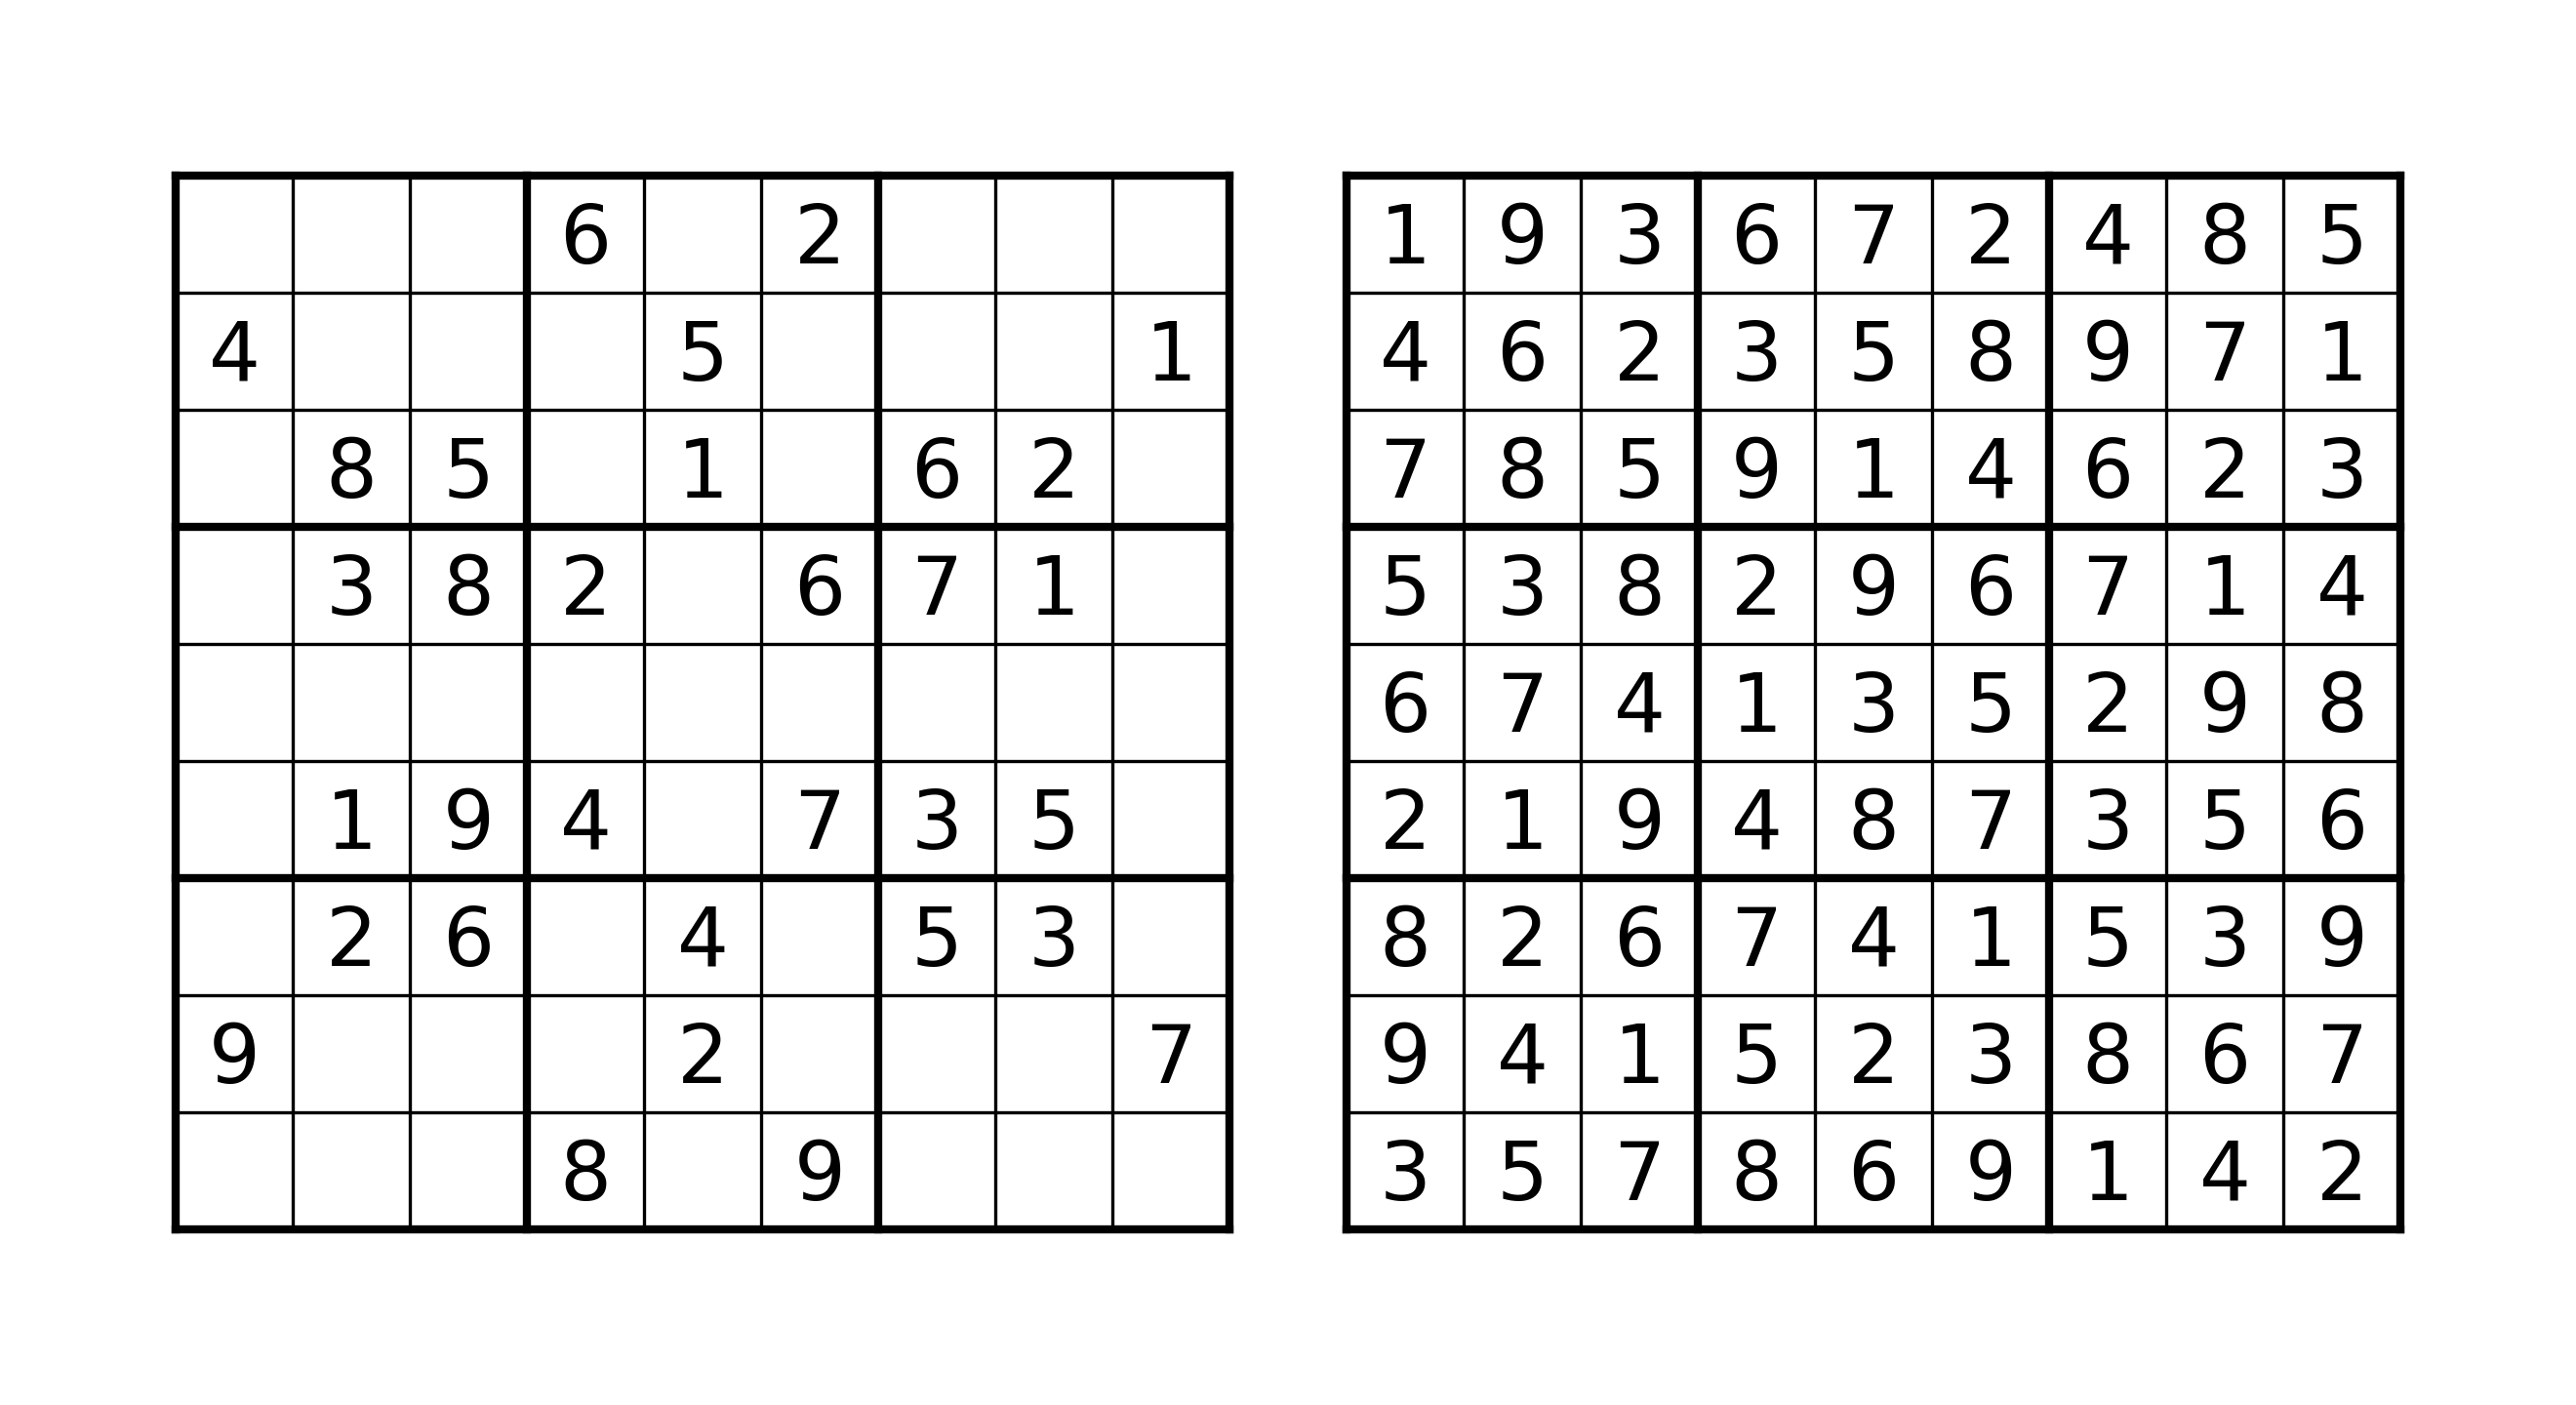

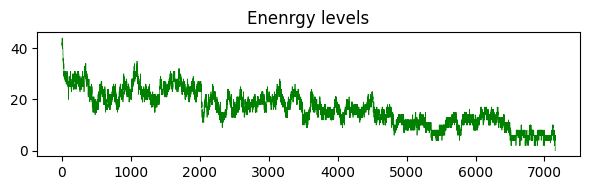

In [452]:
solve("sudoku_przyklady/40.txt")

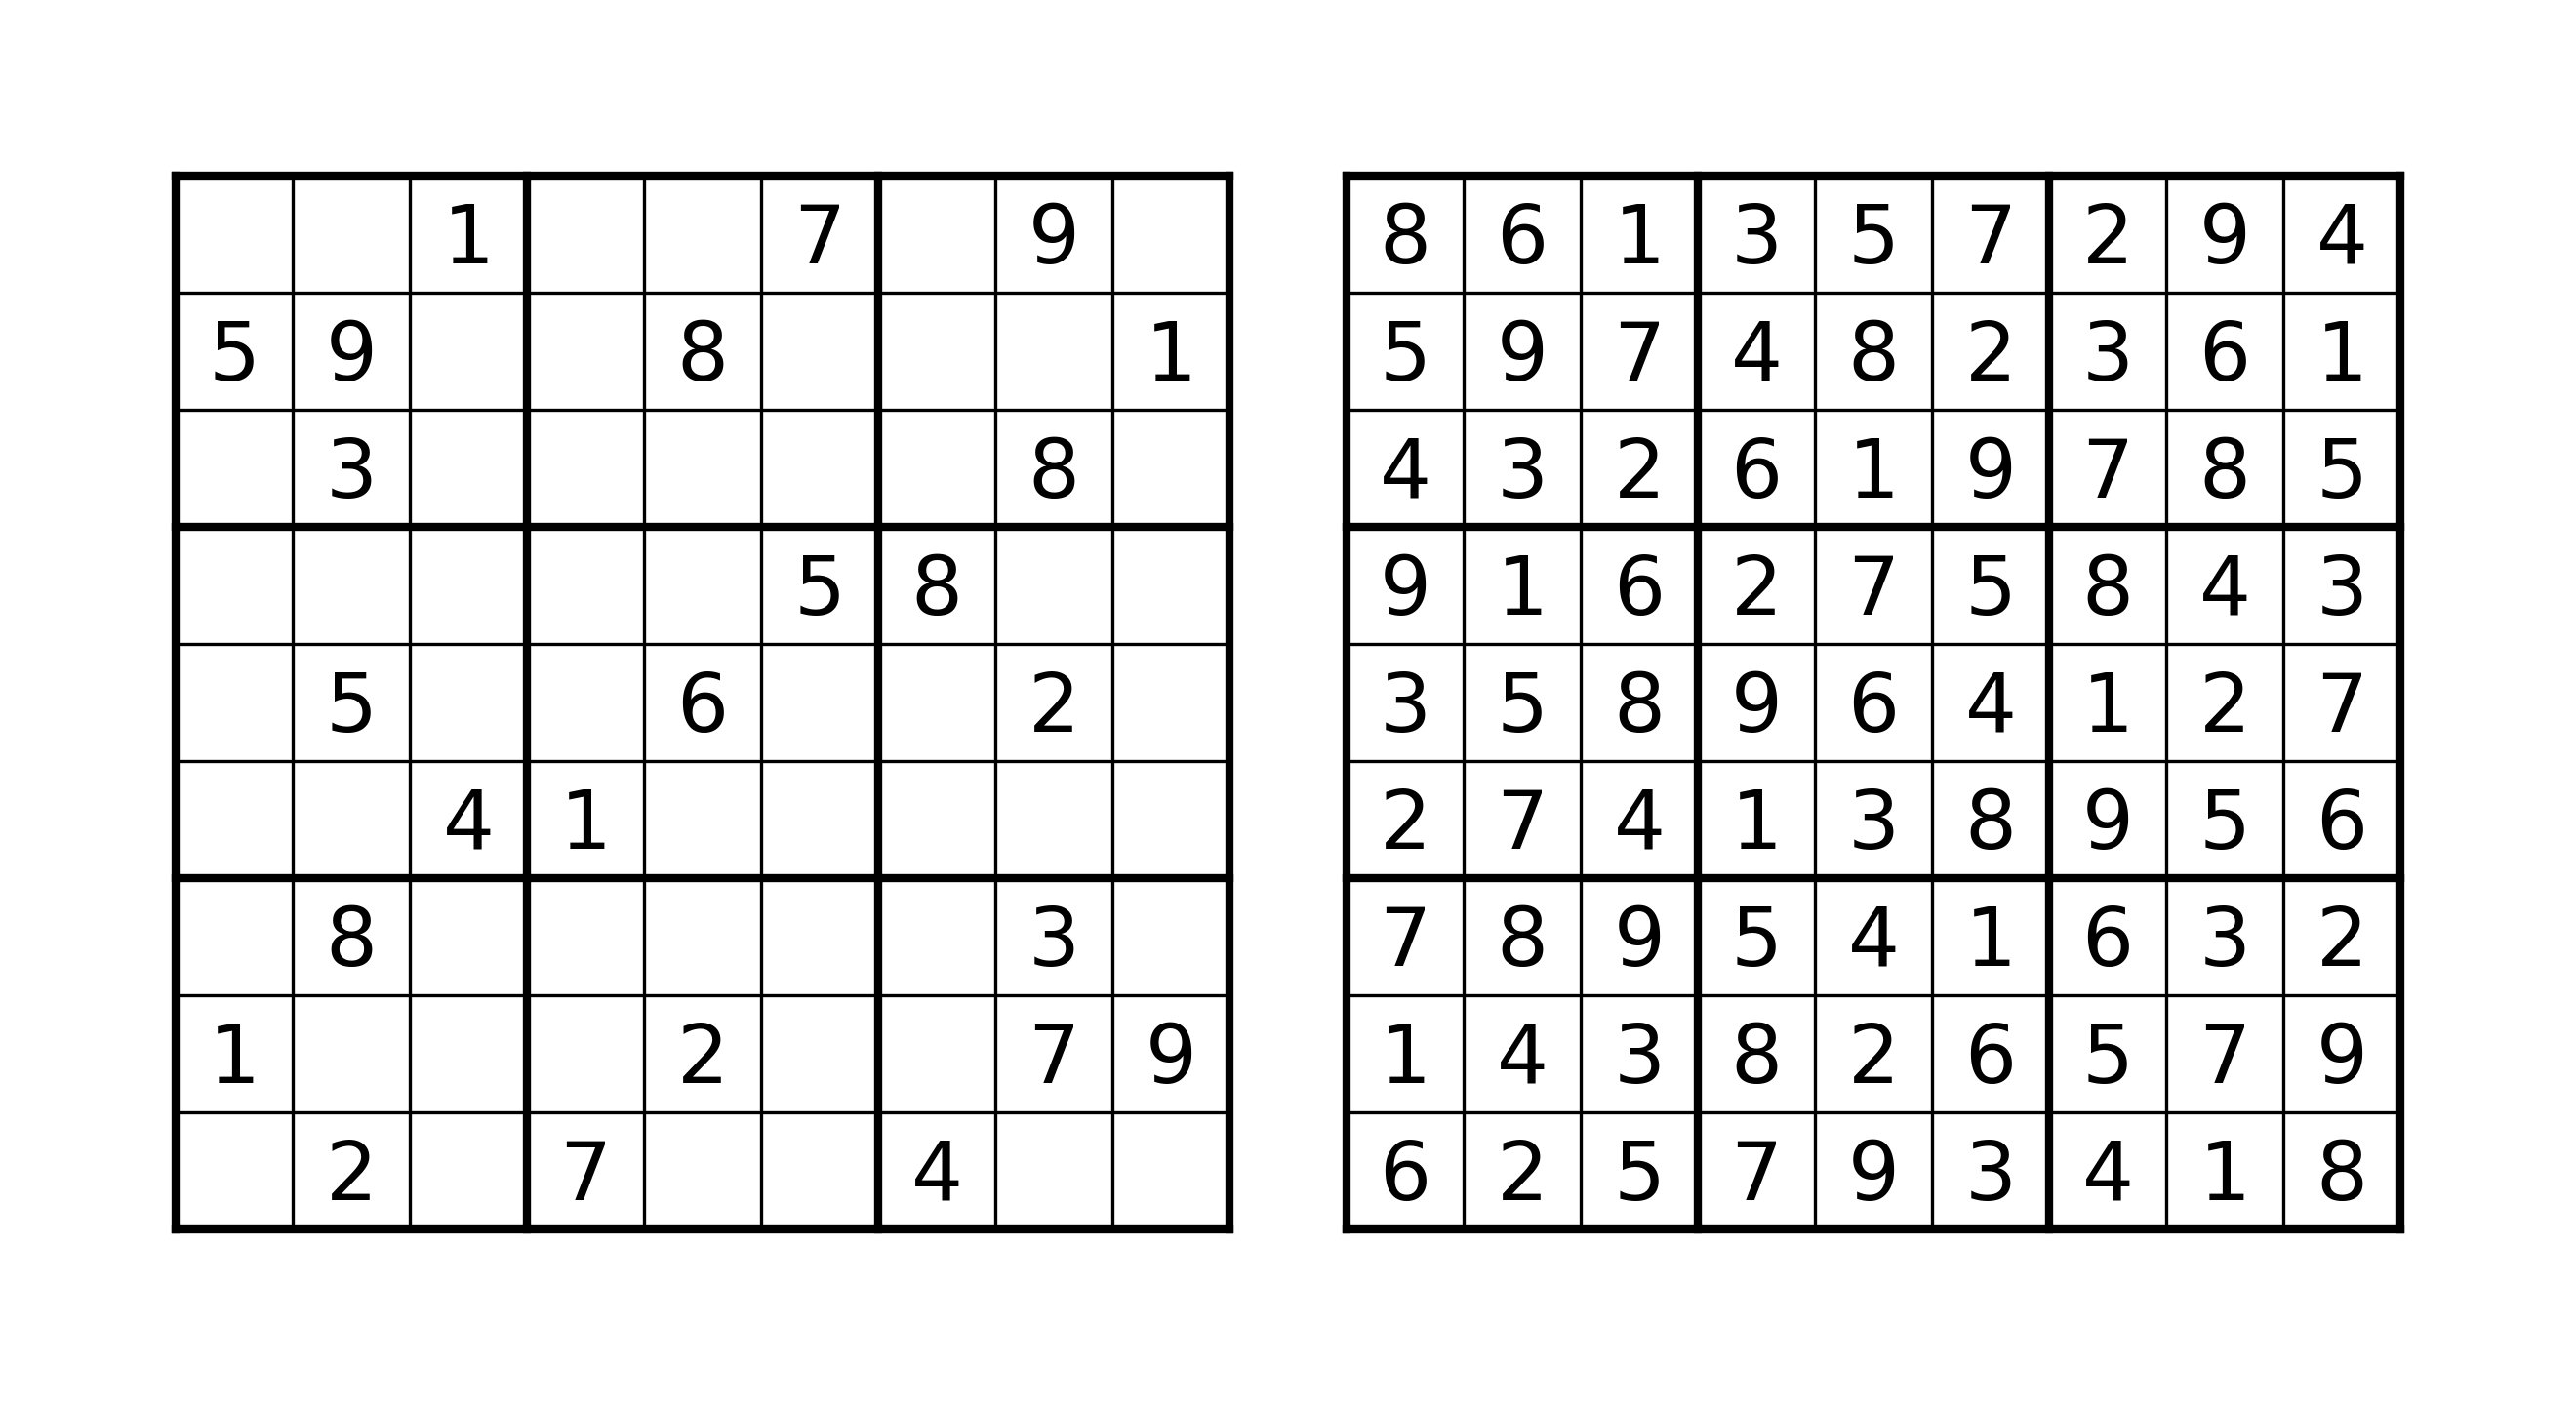

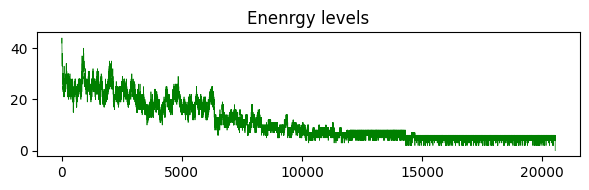

In [442]:
solve("sudoku_przyklady/48.txt")

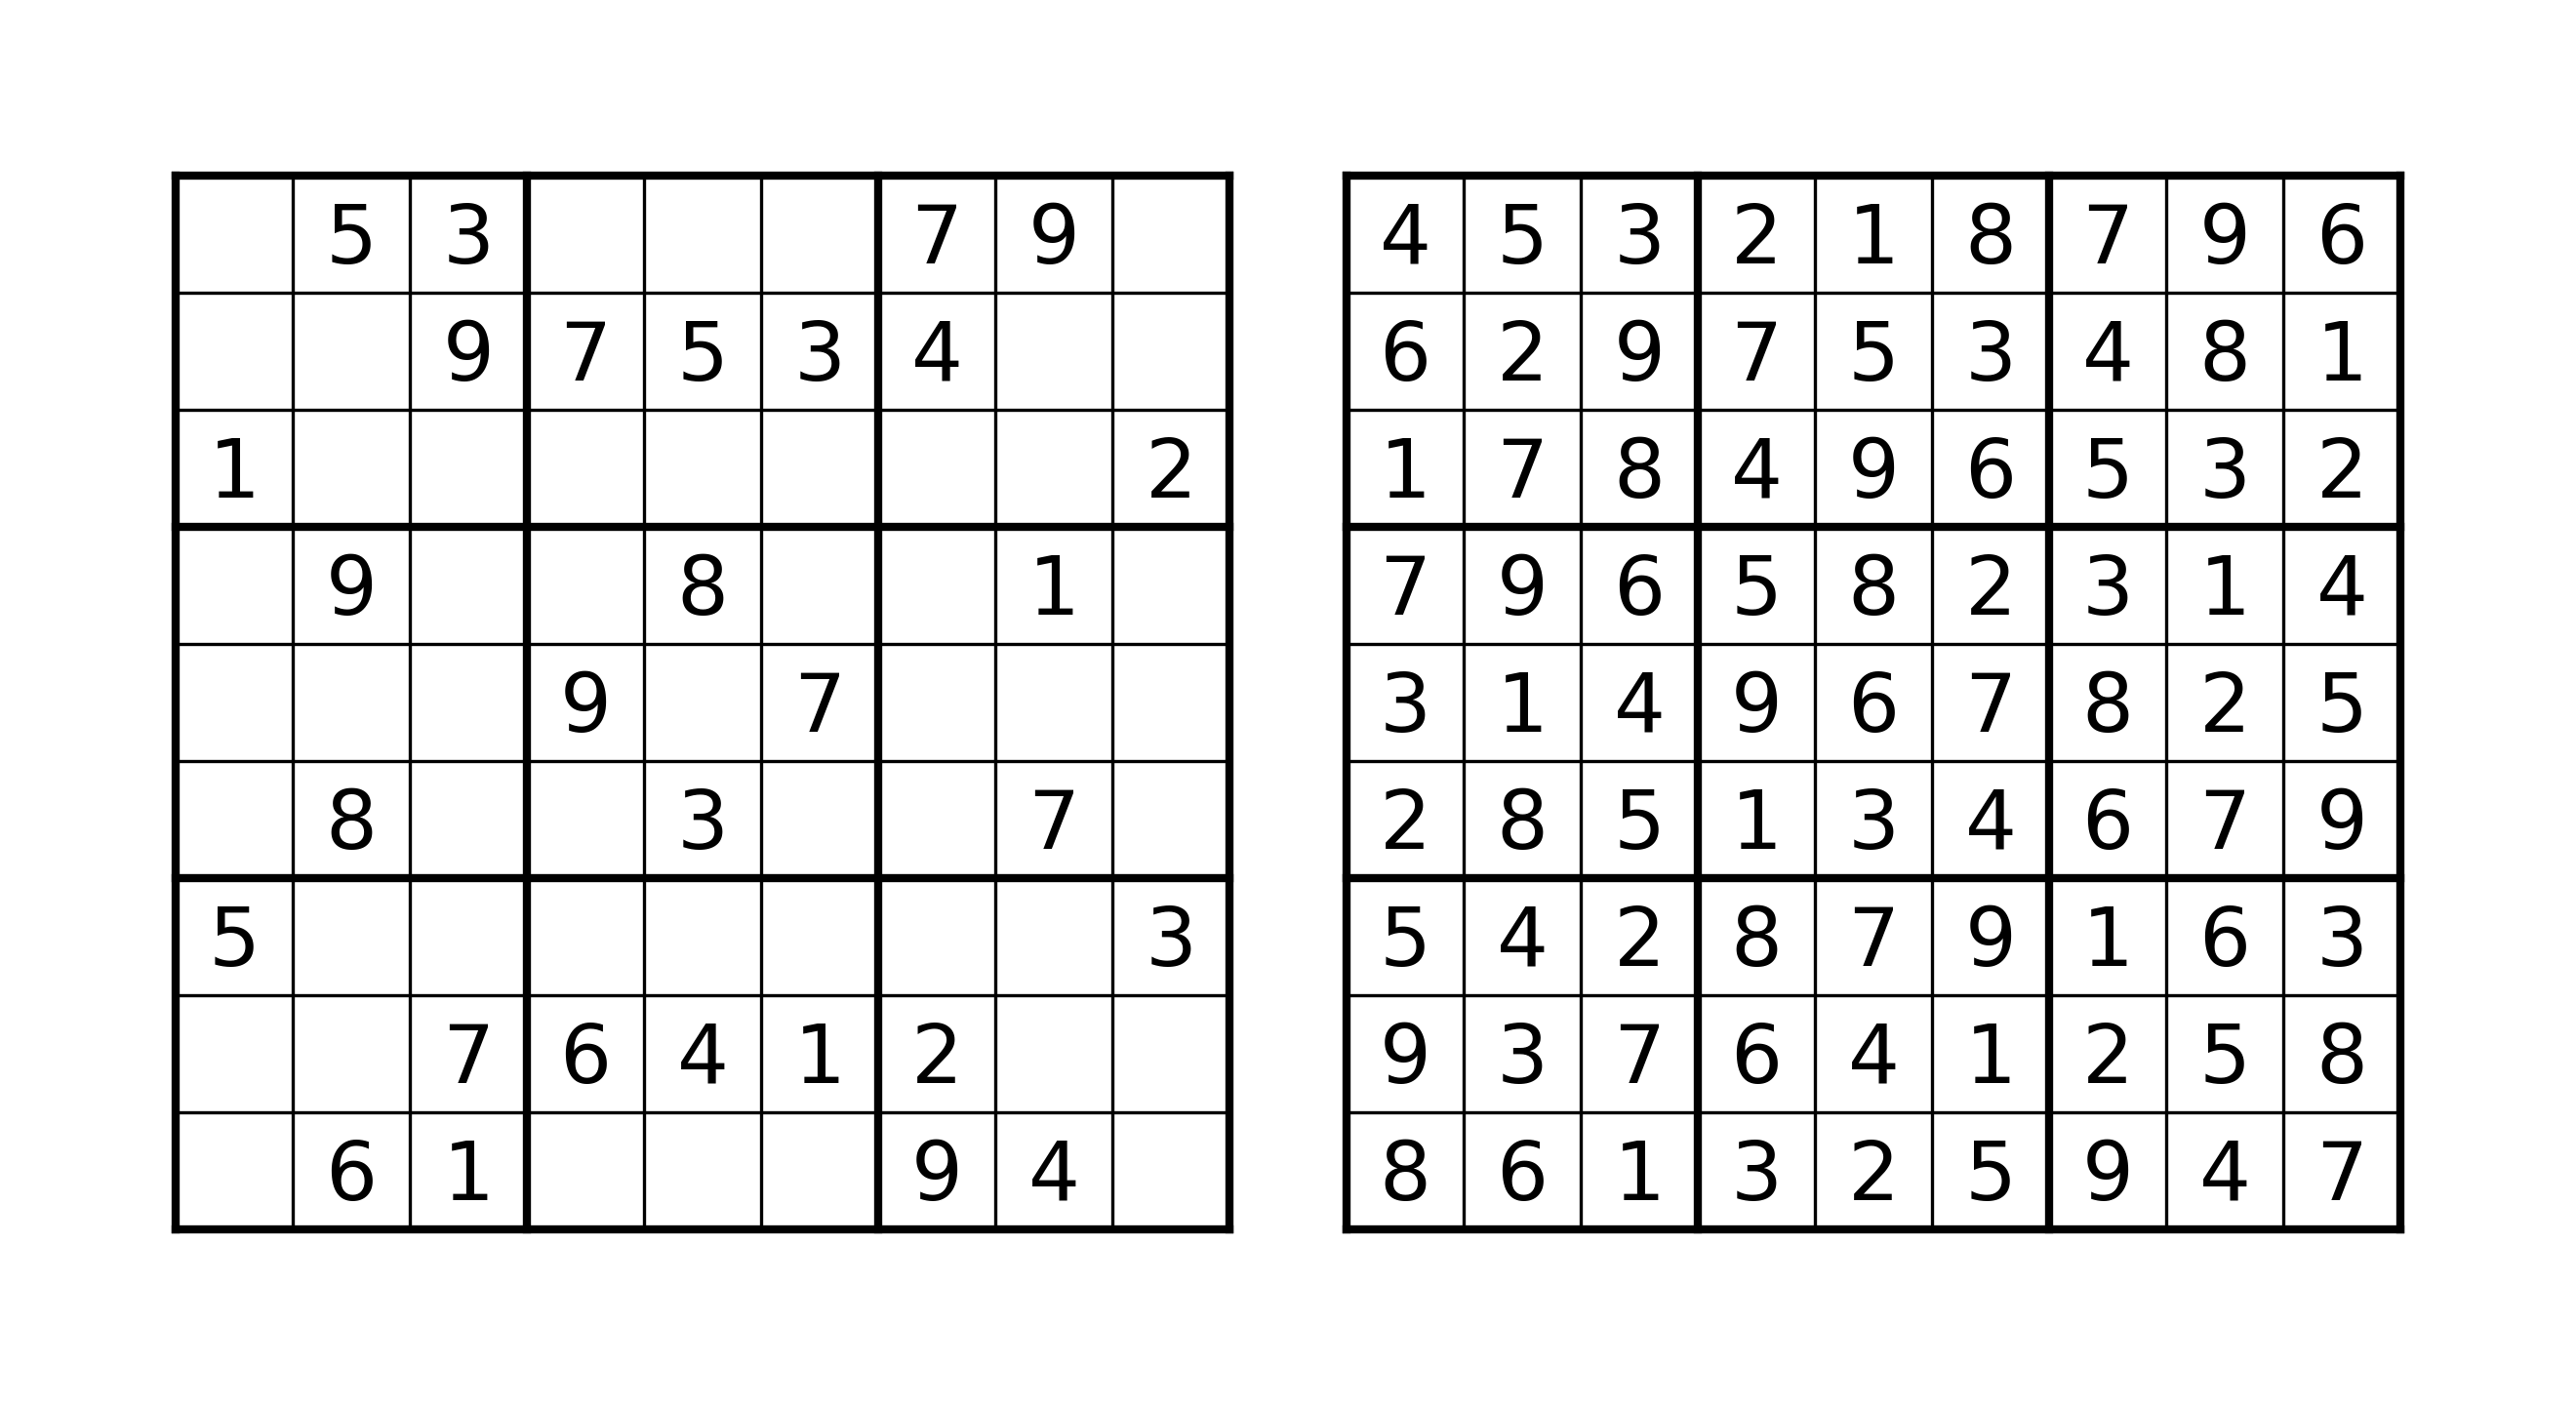

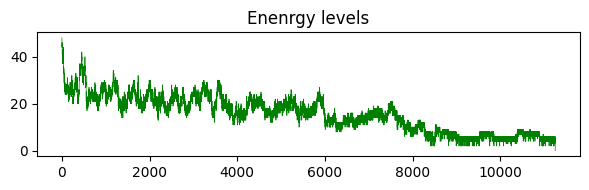

In [446]:
solve("sudoku_przyklady/35.txt")

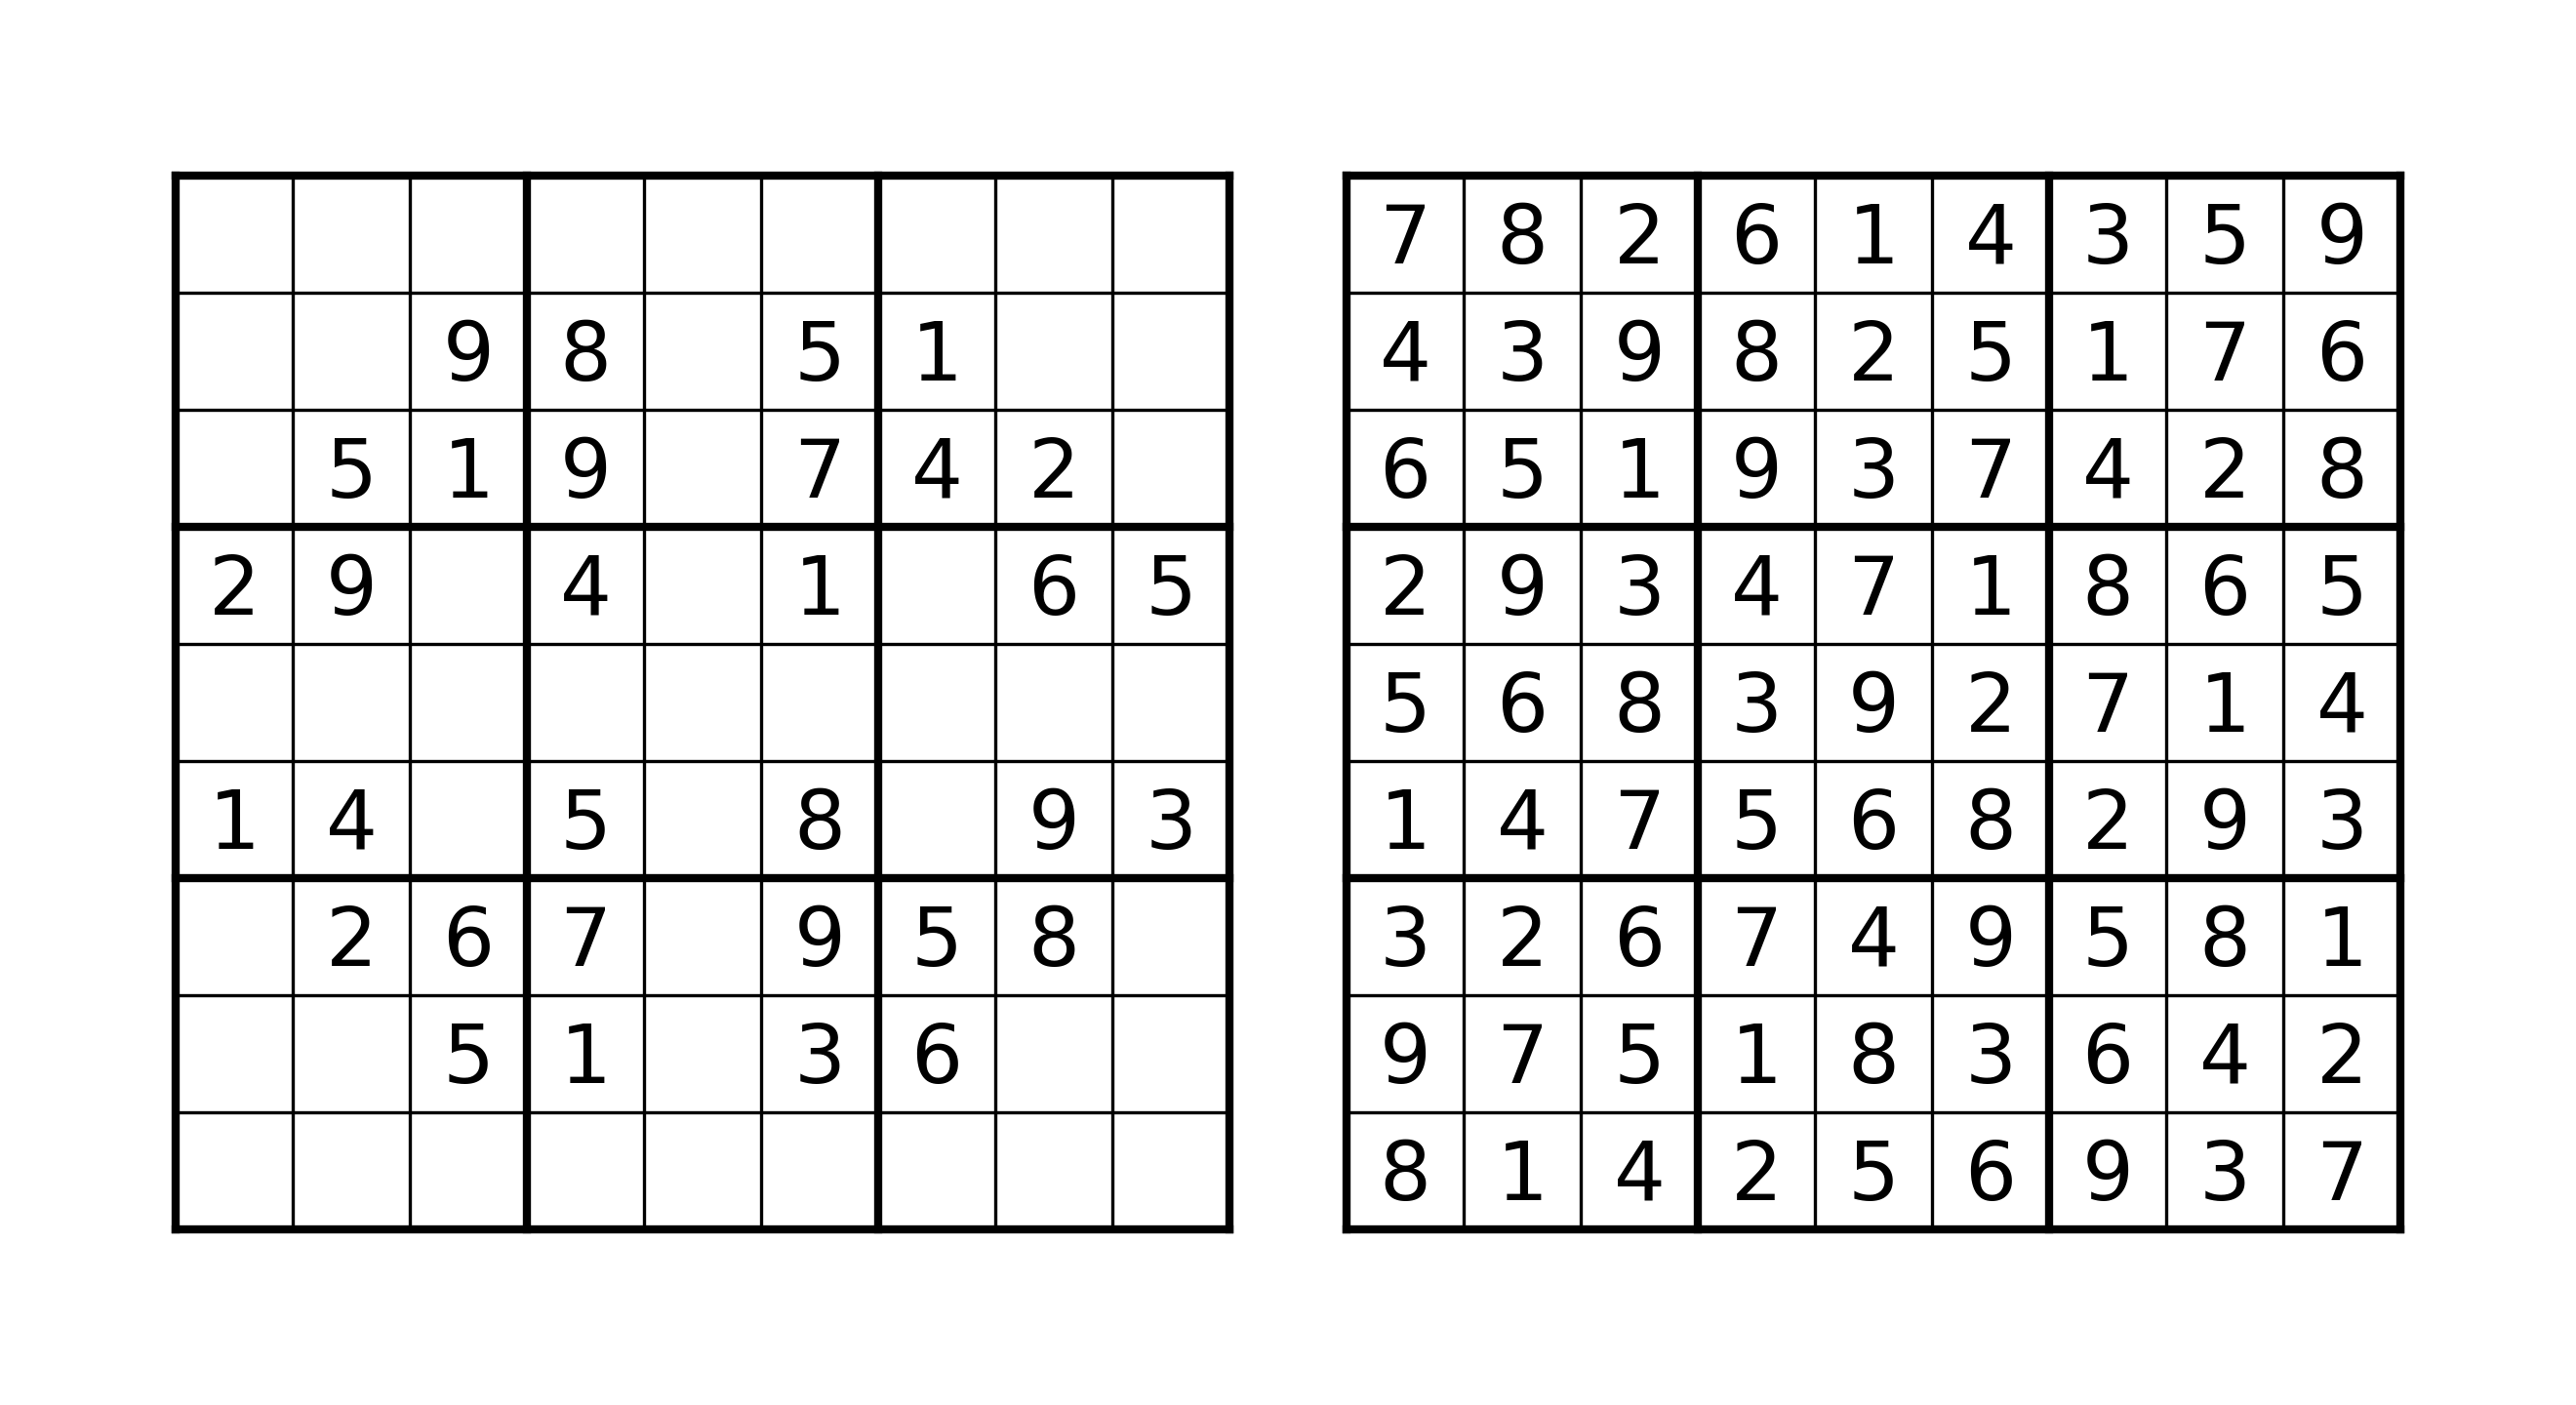

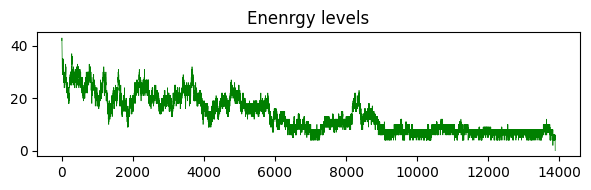

In [448]:
solve("sudoku_przyklady/20.txt")

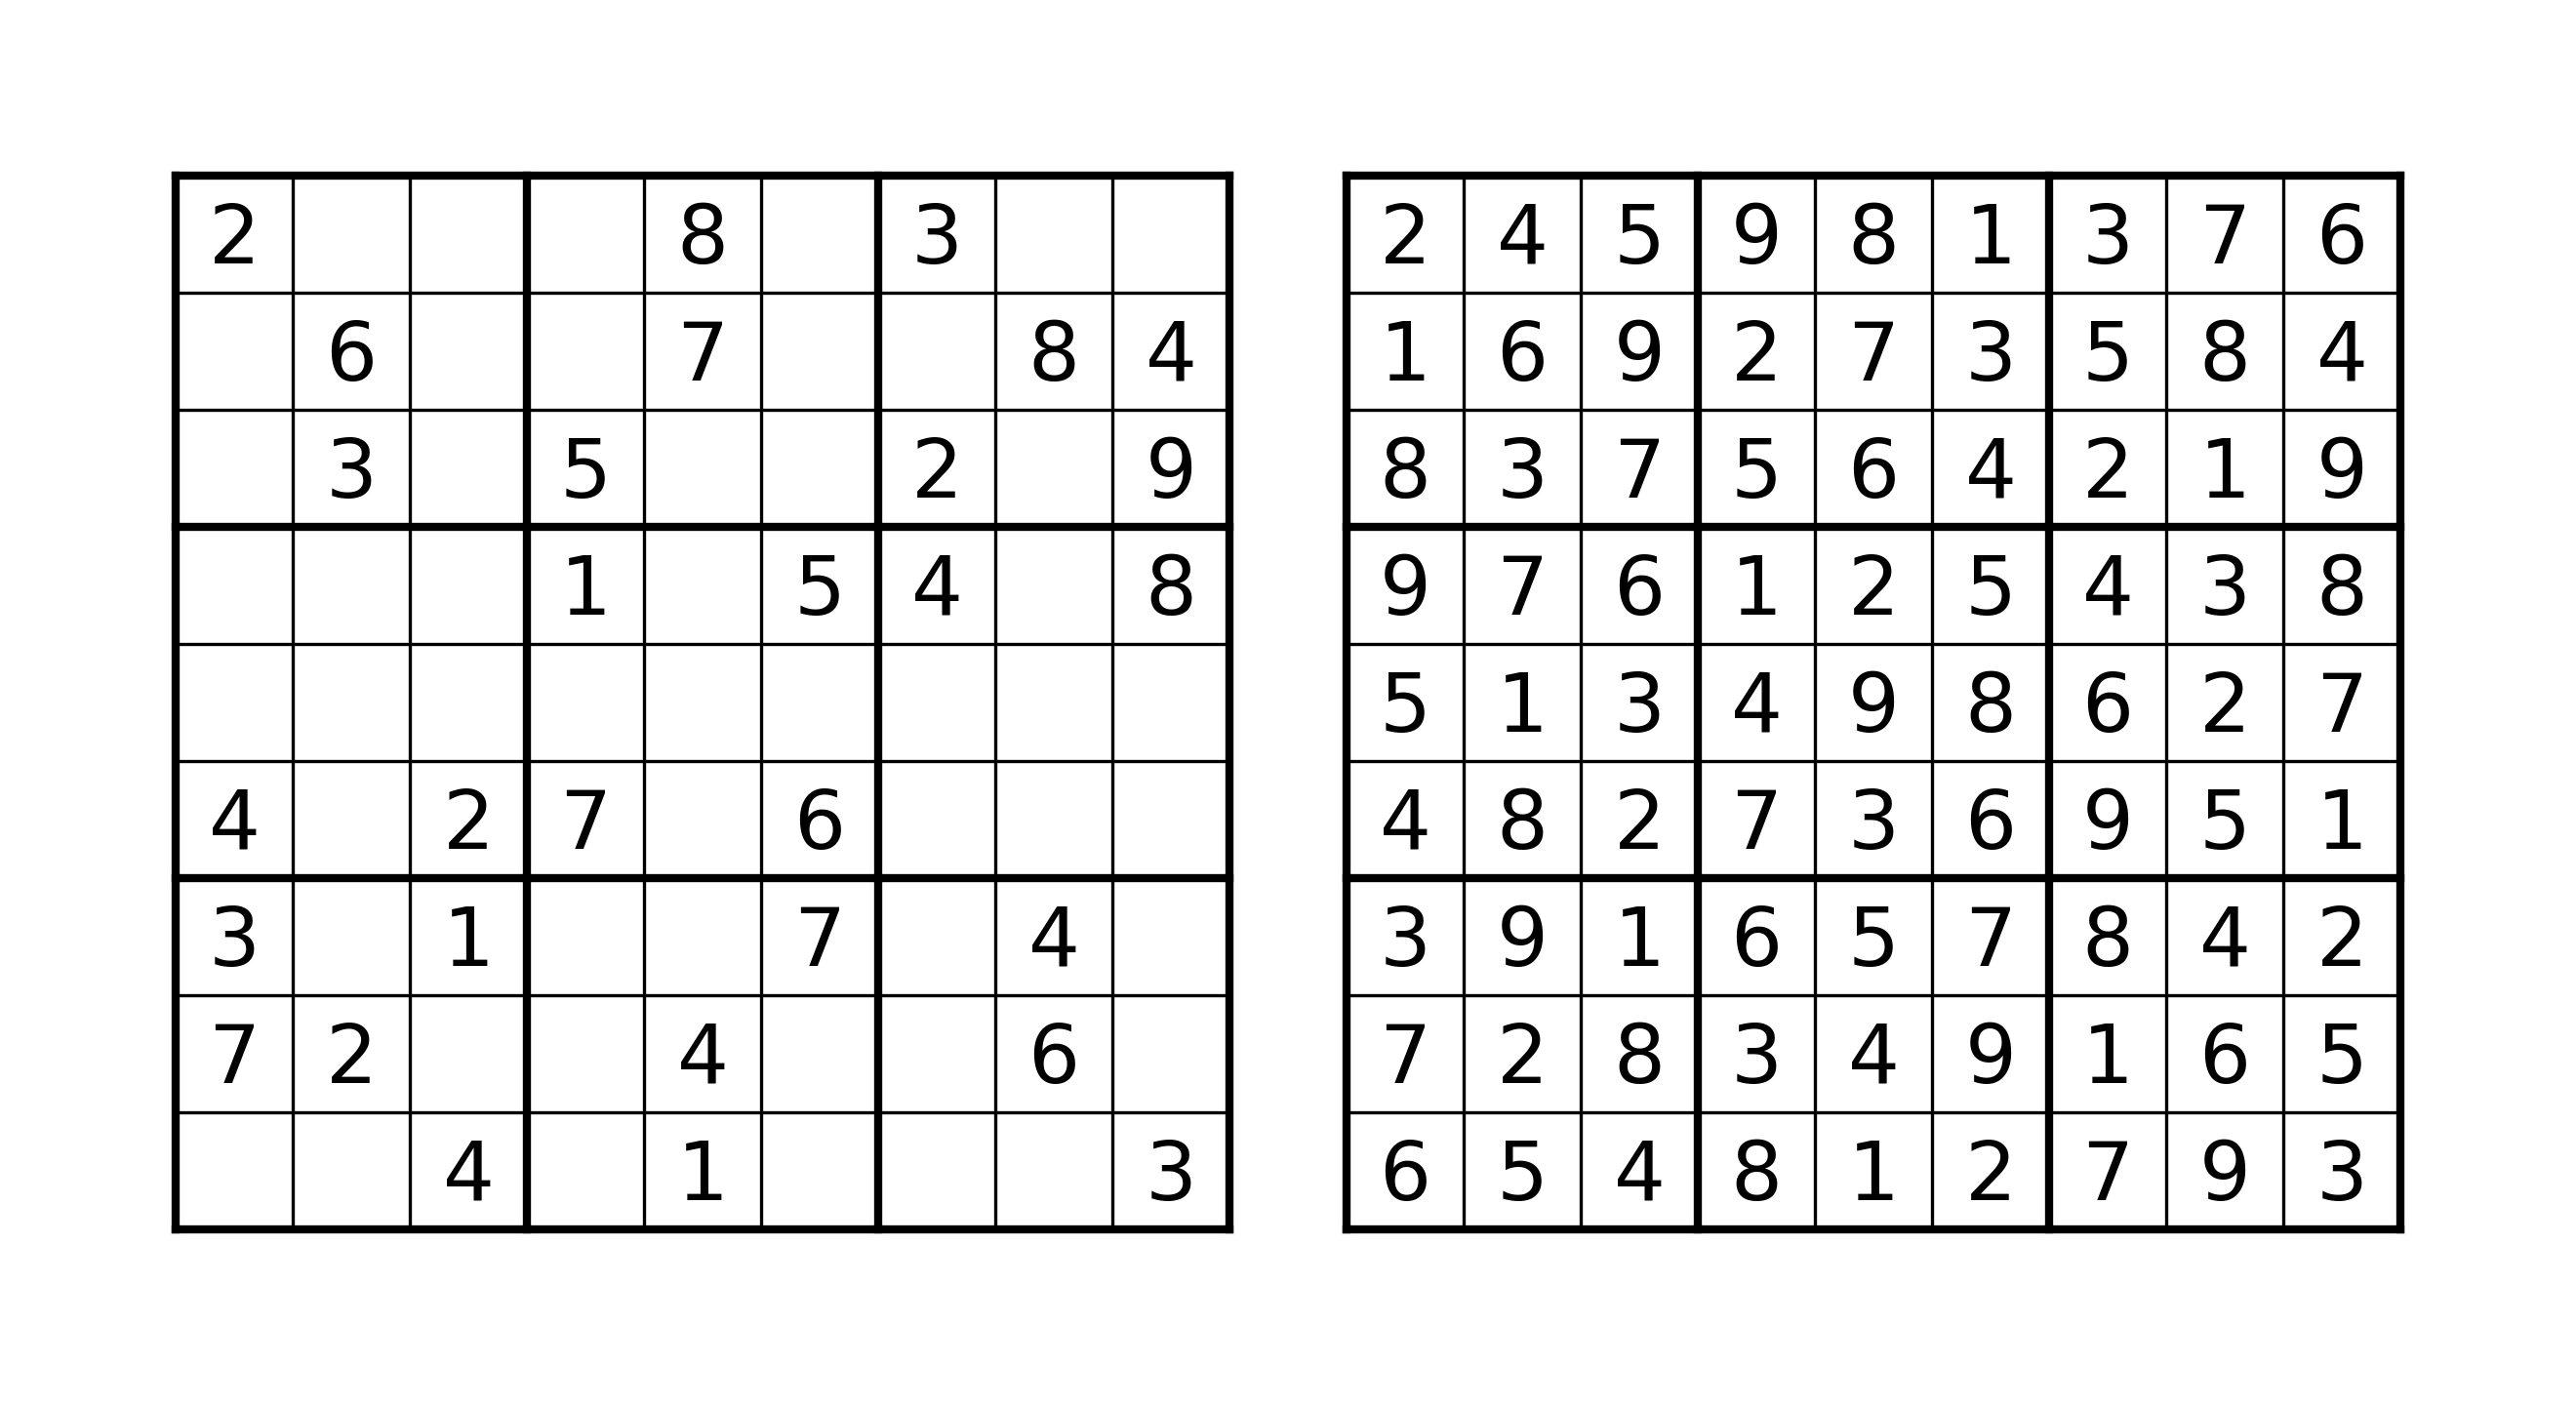

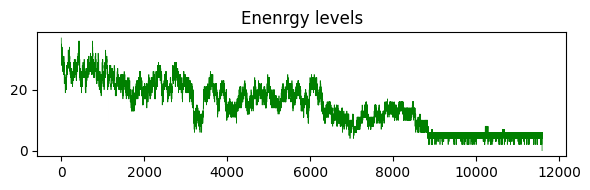

In [453]:
solve("sudoku_przyklady/2.txt")

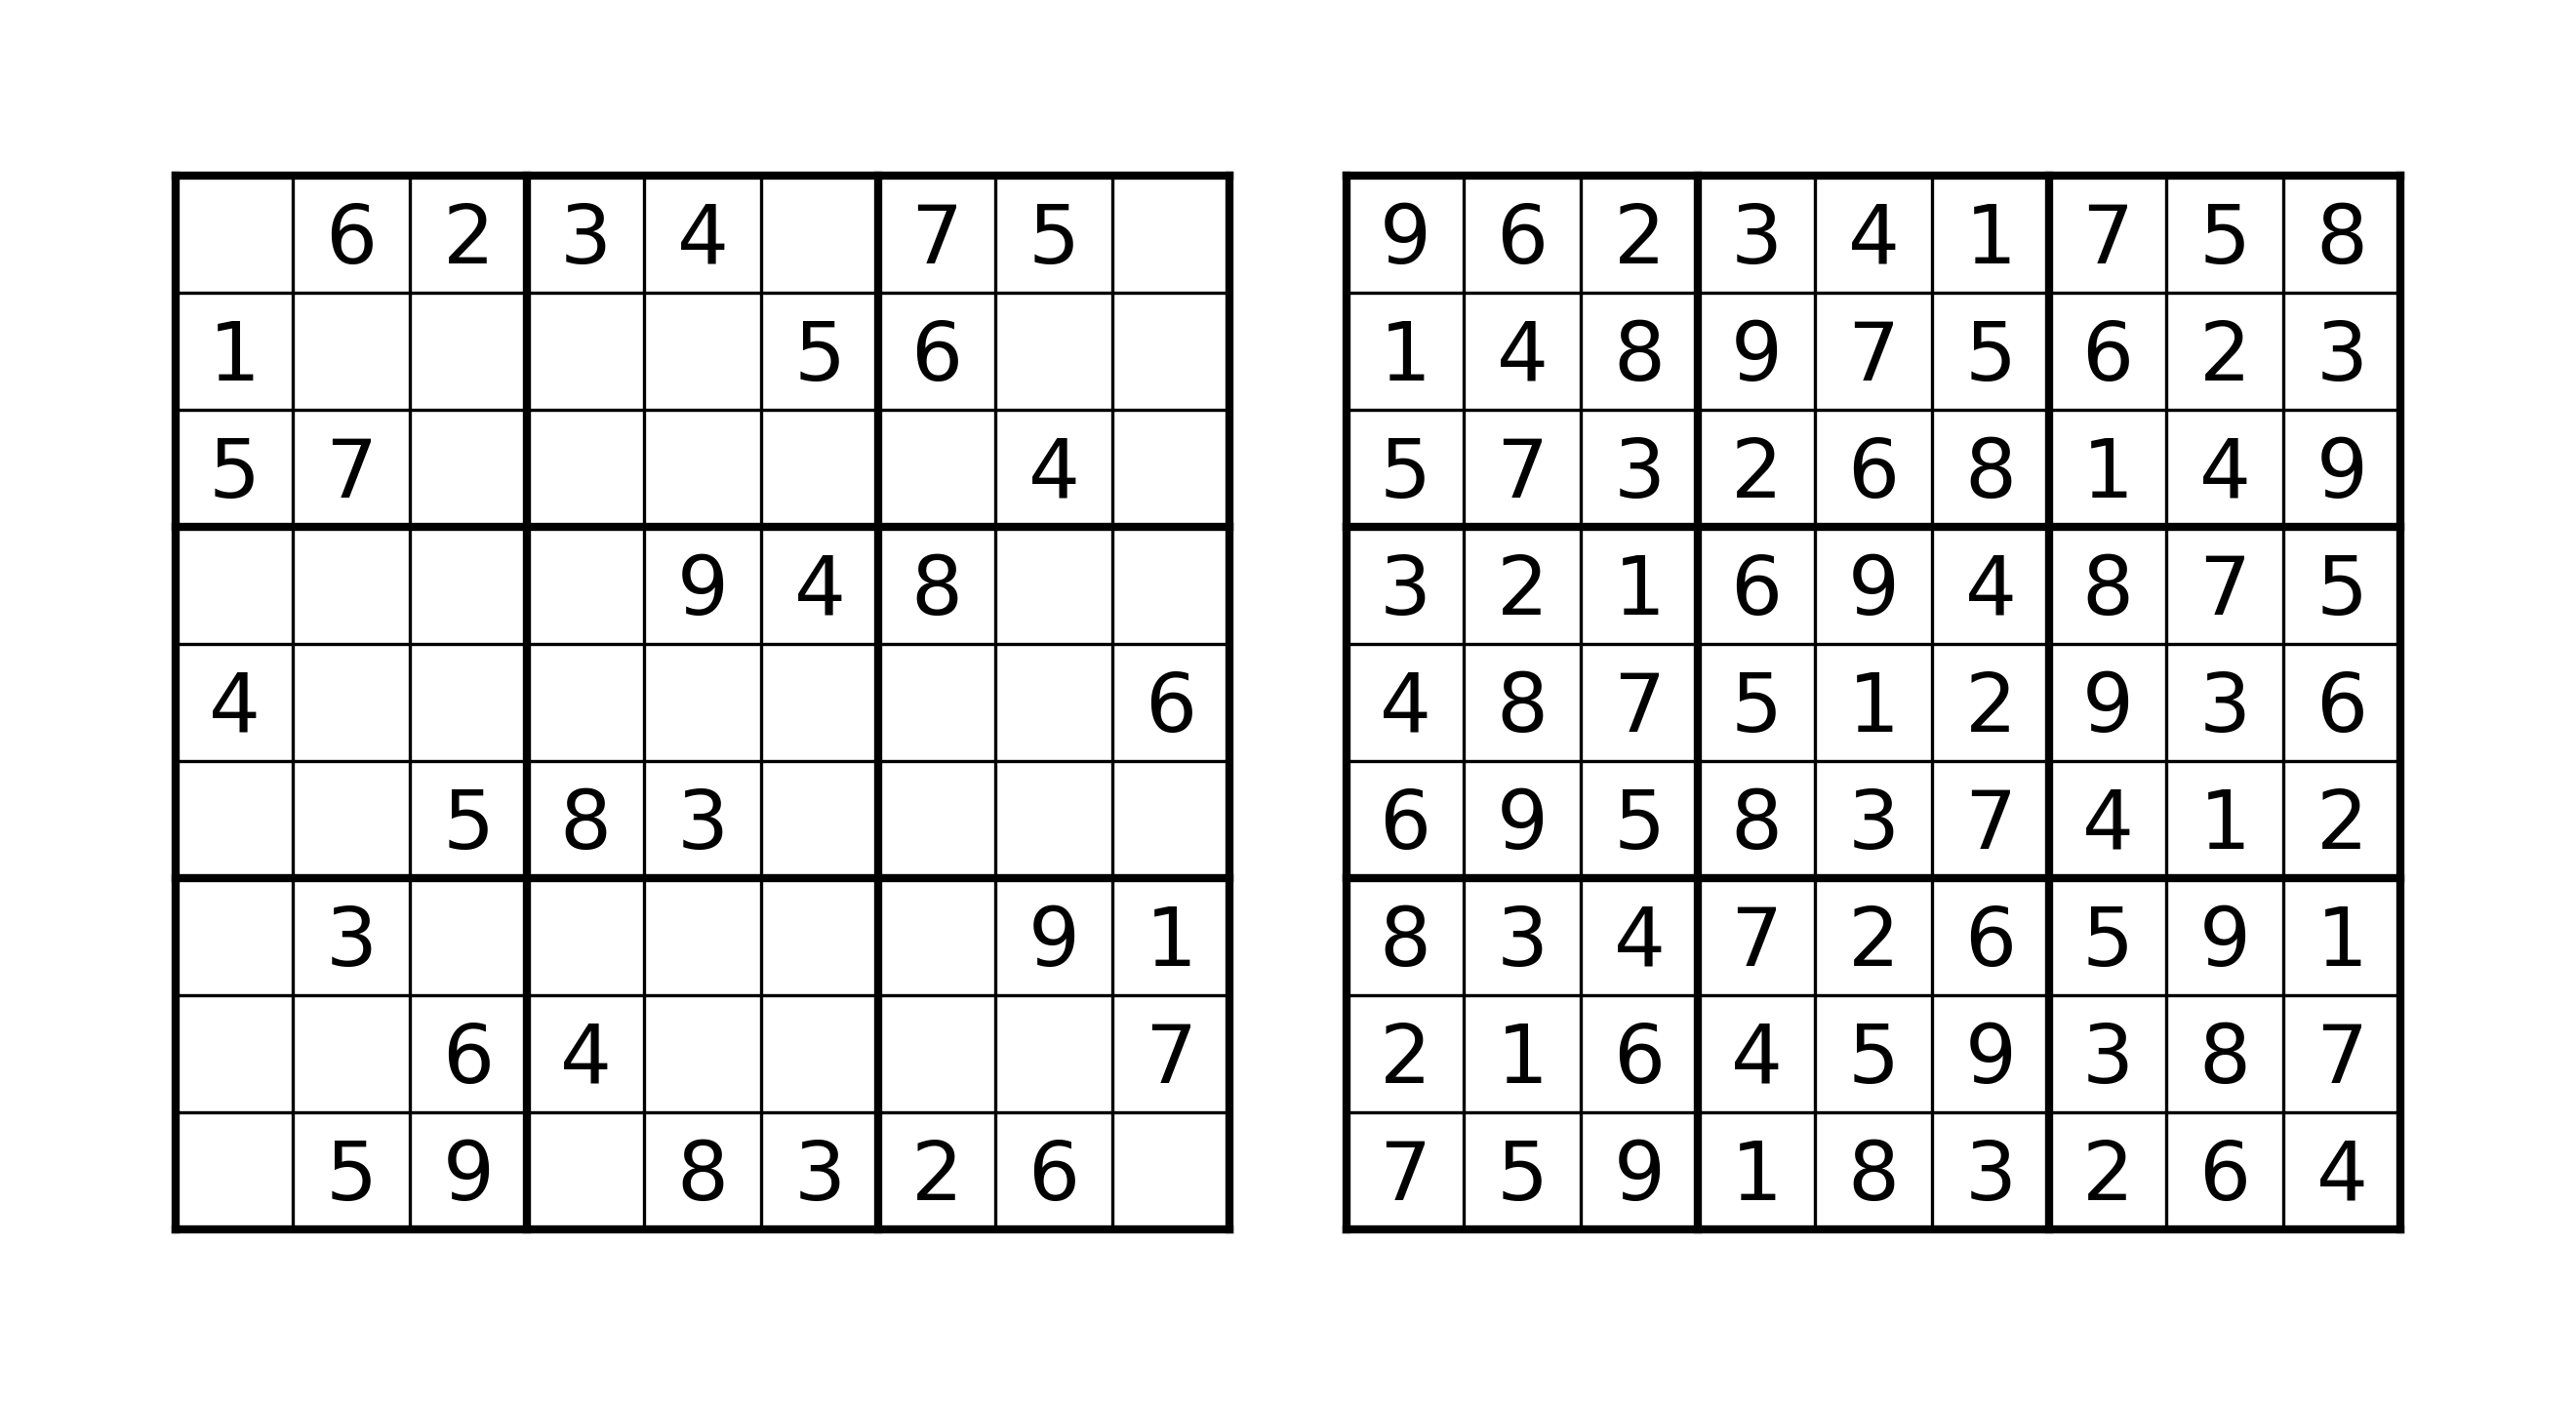

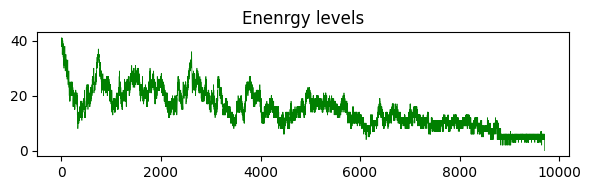

In [454]:
solve("sudoku_przyklady/12.txt")